Analysis made based on paper: <br>
"Time-Series Forecasting of Mortality Rates using Deep Learning" <br>
Written by: <br>
Francesca Perla <br>
Ronald Richman <br>
Salvatore Scognamiglio <br>
Mario V. Wuthrich <br>
Date Written: May 6, 2020

https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3595426

## Setup

### Global options

In [1]:
options(scipen=999)
Sys.setenv(LANG = "en")

### Loading pacakges

In [2]:
library(keras)
library(dplyr)
library(HMDHFDplus)
library(tidyr)
library(R6)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




### Setting working directories  <br>
wd - with other scripts <br>
data_folder - with Mx_1x1

In [3]:
wd <- "/home/as/Pulpit/ADS/Analizy/Own/CNN LC/LC CNN/"
data_folder <- "death_rates/Mx_1x1" 
setwd(wd)

### Setting parameters

In [43]:
ObsYear = 1999 # last year of training set
T0 <- 10 # number of years back used to forecast
model_type = "CNN"
epochs <- 50 #should be 2000 epochs limited due to time constraint         
plotEpochs <- TRUE
plot_interval <- 10

## Function Definition

### mortality_heatmap

In [13]:
mortality_heatmap <- function(mat, country, gender, year_min, year_max){
  m0 <- c(min(mat), max(mat))
  # rows are calendar year t, columns are ages x
  image(z=mat, useRaster=TRUE,  zlim=m0, col=rev(rainbow(n=60, start=0, end=.72)), xaxt='n', yaxt='n', main=list(paste(country," ",gender, " raw log-mortality rates", sep=""), cex=1.5), cex.lab=1.5, ylab="age x", xlab="calendar year t")
  axis(1, at=c(0:(year_max-year_min))/(year_max-year_min), c(year_min:year_max))                   
  axis(2, at=c(0:49)/50, labels=c(0:49)*2)                   
  lines(x=rep((1999-year_min+0.5)/(year_max-year_min), 2), y=c(0:1), lwd=2)
}

### data.preprocessing.CNNs

In [17]:
## transforming HMD data to NN input format
data.preprocessing.CNNs <- function(data.raw, gender, country, T0, ObsYear=1999){    
  mort_rates <- data.raw %>% filter(Gender == gender, Country == country) %>% select(Year, Age, val)
  #mort_rates <- dcast(mort_rates, Year ~ Age, value.var="val")
  mort_rates <- mort_rates %>% pivot_wider(names_from = Age, values_from = val)
  train.rates <- mort_rates %>% filter(Year <= ObsYear) %>% select(-Year) %>% as.matrix()
  YT_year <- mort_rates %>% filter(Year <= ObsYear)%>% select(Year) %>% unlist() %>% unname()
  YT_year <- tail(YT_year, -10) # omit first 10 years (used only as x)
  n.train <- nrow(train.rates)-(T0-1)-1 # number of training samples
  xt <- array(NA, c(n.train, T0, 100))
  YT <- array(NA, c(n.train, 100))
  for (t0 in (1:n.train)){
    xt[t0,,] <- train.rates[t0:(t0+T0-1), ]
    YT[t0,] <-   train.rates[t0+T0,]
  }
  list(xt, YT, YT_year)
}

### recursive.prediction

In [34]:
recursive.prediction <- function(ObsYear, all_mort2, gender, country_name, country_index, T0, val.min, val.max, model.p){       
  single.years <- array(NA, c(2016-ObsYear))
  
  for (ObsYear1 in ((ObsYear+1):2016)){
    data1 <- all_mort2 %>% filter(Year >= (ObsYear1-10))
    data2 <- data.preprocessing.CNNs(data1, gender, country_name,T0, ObsYear1)
    # MinMaxScaler (with minimum and maximum from above)
    x.vali <- data2[[1]]
    if (gender=="Female"){yy <- 1}else{yy <- 0}
    x.vali <- list(x.vali, rep(country_index, dim(x.vali)[1]), rep(yy, dim(x.vali)[1]))
    y.vali <- data2[[2]]
    predicted_val <- model %>% predict(x.vali) %>% as.vector()
    predicted_logmx <- (predicted_val*(val.max-val.min)+ val.min)
    Yhat.vali2 <- exp(predicted_logmx)
    ## error calculated on transformed data, in line with Salvatore comment
    single.years[ObsYear1-ObsYear] <- round(10^4*mean((predicted_val-y.vali)^2),4)
    
    predicted <- all_mort2 %>% filter(Year==ObsYear1, Gender == gender, Country == country_name) # [which(all_mort2$Year==ObsYear1),]
    keep <- all_mort2 %>% filter(Year!=ObsYear1, Gender == gender, Country == country_name)
    predicted$logmx <- predicted_logmx
    predicted$mx <- exp(predicted$logmx)
    predicted$val <- predicted_val
    all_mort2 <- rbind(keep,predicted)
    all_mort2 <- all_mort2 %>% arrange(Year, Age)
  }
  list(all_mort2, single.years)
}

## Models specification

### CNN model

In [19]:
#Listing 1: Deep neural network model LCCONV with a 1d-CNN layer.

CNN <- function(N,T0, optim="adam"){
rates <- layer_input(shape = c(T0 ,100) , dtype = 'float32', name = 'rates')

# Country Embedding

Country <- layer_input(shape = c(1) , dtype = 'int32' , name = 'Country')
Country_embed = Country %>%
  layer_embedding(input_dim = N , output_dim = 5) %>%
  layer_flatten(name = 'Country_embed')

# Gender Embedding
# We have seen that using a larger dimension for gender embedding improves
# performance in mortality forecasting, because this allows us for more flexible
# interactions in gradient descent calibrations between gender, age and region.

Gender <- layer_input(shape = c(1), dtype = 'int32' , name = 'Gender')
Gender_embed = Gender %>%
  layer_embedding(input_dim = 2 , output_dim = 5) %>%
  layer_flatten(name = 'Gender_embed')

conv = rates %>% layer_conv_1d(filter = 32 , kernel_size = 3 , # kernel_size = m, filter = q from paper
                               activation = 'linear' , padding = "causal") %>%
  layer_max_pooling_1d(pool_size = 2) %>%
  layer_batch_normalization() %>%
  layer_dropout(rate = 0.35) %>%
  layer_flatten()

# decoding z(r, g, U(t0)) results to mortality rates by multivariate GLM (using FCN Layer)
  
decoded = conv %>% list(Country_embed, Gender_embed)%>%
  layer_concatenate() %>%
  layer_dropout(rate = 0.4) %>%
  layer_dense(units = 100 , activation = 'sigmoid') %>%
  layer_reshape(c(1,100) , name = 'forecast_rates')

model <- keras_model(inputs = list(rates, Country, Gender) , outputs = c(decoded))
model %>% compile(loss = 'mean_squared_error', optimizer = optim, metrics = c('mse'))
    return(model)
}

### LSTM Model

In [20]:
## Listing 2: Deep neural network model LCLSTM1 with a LSTM layer
LSTM <- function(N,T0, optim="adam"){
rates <- layer_input(shape = c(T0 ,100) , dtype = 'float32' , name = 'rates')
#
Country <- layer_input( shape = c(1) , dtype = 'int32' , name = 'Country')
Country_embed = Country %>%
  layer_embedding(input_dim = N , output_dim = 5) %>%
  layer_flatten(name = 'Country_embed')
#
Gender <- layer_input(shape = c(1) , dtype = 'int32' , name = 'Gender')
Gender_embed = Gender %>%
  layer_embedding(input_dim = 2 , output_dim = 5) %>%
  layer_flatten(name = 'Gender_embed')
#
LSTM1 = rates %>% layer_lstm(units = 128 , activation = "linear" ,
                                recurrent_activation = "tanh", return_sequences = F ) %>%
  layer_batch_normalization() %>%
  layer_dropout (rate = 0.35)
#
decoded = LSTM1 %>% list ( Country_embed , Gender_embed )%>%
  layer_concatenate() %>%
  layer_dropout ( rate = 0.4) %>%
  layer_dense ( units = 100 , activation = 'sigmoid') %>%
  layer_reshape ( c(1 ,100) , name = 'forecast_rates')
#
model <- keras_model( inputs = list ( rates , Country , Gender ) , outputs = c ( decoded ))
model %>% compile(loss = 'mean_squared_error', optimizer = optim)
return(model)
}

## Data reading and preprocessing

reading the data from Mx_1x1 tables from HMD for Countries listed in appendix A of paper: <br>
A Neural Network Extension of the Lee-Carter Modelto Multiple Populations Ronald Richman, Mario V. Wuthrich (Version of October 22, 2018)


In [5]:
stat <- "Mx_1x1"
filetype <- "txt"

countries <- c("AUS", "AUT", "BEL", "BGR", "BLR", "CAN","CHE","CHL","CZE","DEUTNP","DNK",
                 "ESP", "EST", "FIN", "FRATNP", "GBRTENW", "GBR_NIR", "GBR_SCO",
                 "GRC", "HRV", "HUN", "IRL", "ISL", "ISR", "ITA", "JPN", "LTU", "LUX", "LVA",
                 "NLD", "NOR", "NZL_NM", "POL", "PRT", "RUS", "SVK", "SVN","SWE", "TWN", "UKR", "USA")


files <- paste(countries, stat, filetype, sep = ".")
long_dir_files <- paste(data_folder,files, sep="/")

HMD_list <- list()

### Reading data from files in HMD format
filtering the data by Age (<100) and Year(1950 <= Year <= 2016) <br>
getting rid of columns "Total" and "OpenInterval" <br>
pivoting the data to create column Gender and column mx from columns "Female" and "Male" <br>


In [6]:
for (i in 1:length(long_dir_files)){
HMD_list[[countries[i]]] <- readHMD(long_dir_files[i]) %>% filter(Year >= 1950 & Year <= 2016 & Age < 100) %>% 
                            select(-c(Total,OpenInterval)) %>% 
                            pivot_longer(c(Female,Male), names_to = "Gender", values_to = "mx" )
}

HMD_data <- bind_rows(HMD_list, .id = "Country")

### Data transformation and imputation
Choosing the countries with more than 10 years of observation before year 2000


In [8]:
Analyzed_Countries <- HMD_data %>% select(Country, Year) %>% distinct() %>% filter(Year < 2000) %>% 
                      group_by(Country) %>% summarise(n= n()) %>% filter(n>10) %>% select(Country) %>% unlist()

HMD_data_chosen <- HMD_data %>% filter(Country %in% Analyzed_Countries)

`summarise()` ungrouping output (override with `.groups` argument)



setting mx to NA if mx =< 0

In [9]:
HMD_data_chosen <- HMD_data_chosen %>% 
  mutate(mx = if_else(mx > 0, mx, NA_real_))

imputting values with NA in mx column by average by Age, Gednder and Year from all countries read in point 1

In [10]:
toImpute <- HMD_data_chosen %>% filter(mx >0) %>% group_by(Age, Gender, Year) %>% summarize(mx_avg = mean(mx))

HMD_final <- HMD_data_chosen %>% inner_join(toImpute, by = c("Age", "Gender", "Year")) %>%
                  mutate(imputed_flag = is.na(mx), mx = if_else(is.na(mx),mx_avg,mx), logmx = log(mx)) %>% 
                  select(-mx_avg)



`summarise()` regrouping output by 'Age', 'Gender' (override with `.groups` argument)



Cleaning the enviroment after data reading

In [11]:
rm(list = c("HMD_data_chosen","toImpute","Analyzed_Countries","HMD_data", "HMD_list", "files", "countries", "filetype","stat", "i"))

In [12]:
# number of countries
N <- HMD_final %>% select(Country) %>% distinct() %>% nrow()

### Data visualization - Heatmaps

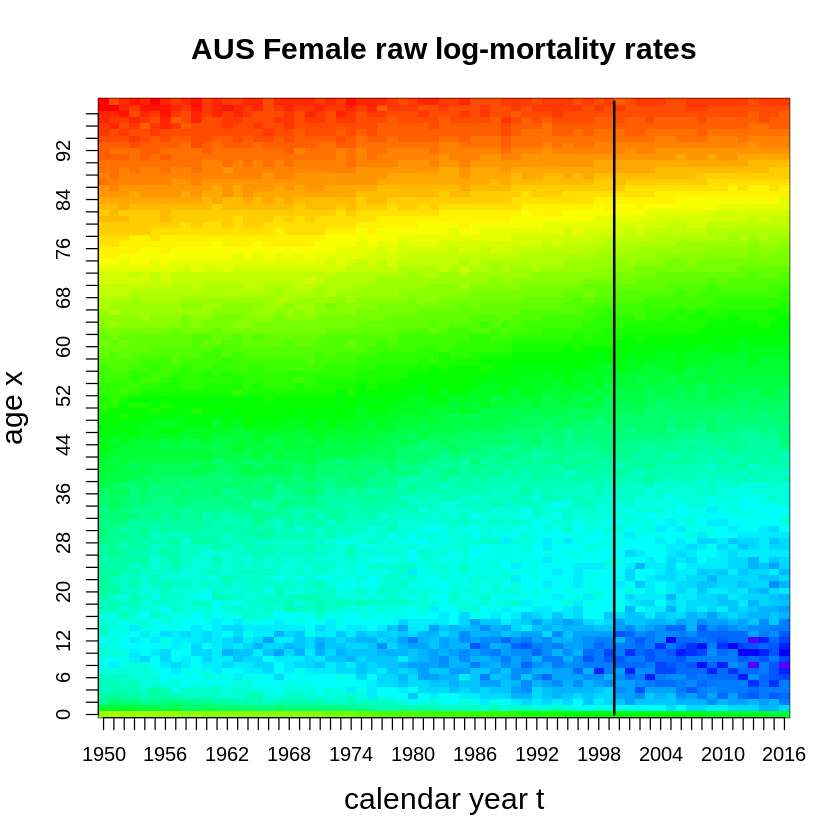

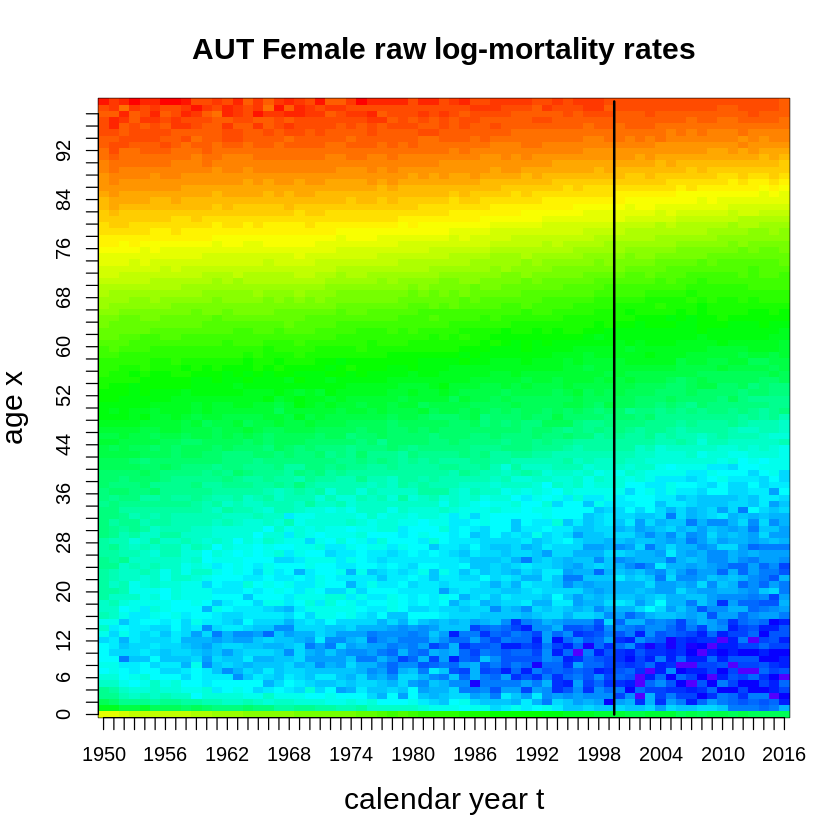

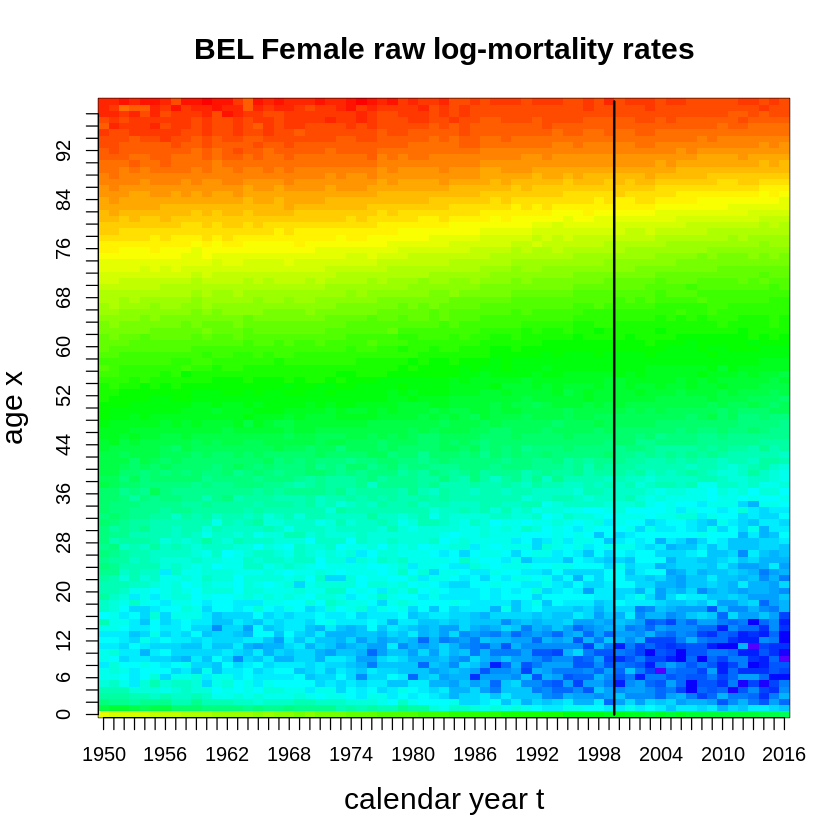

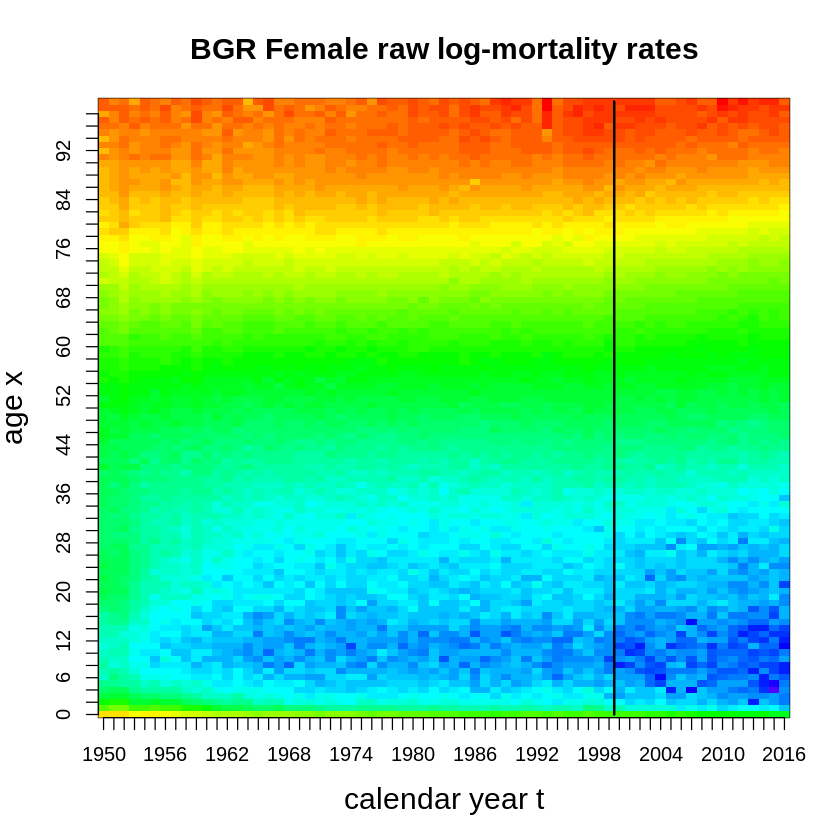

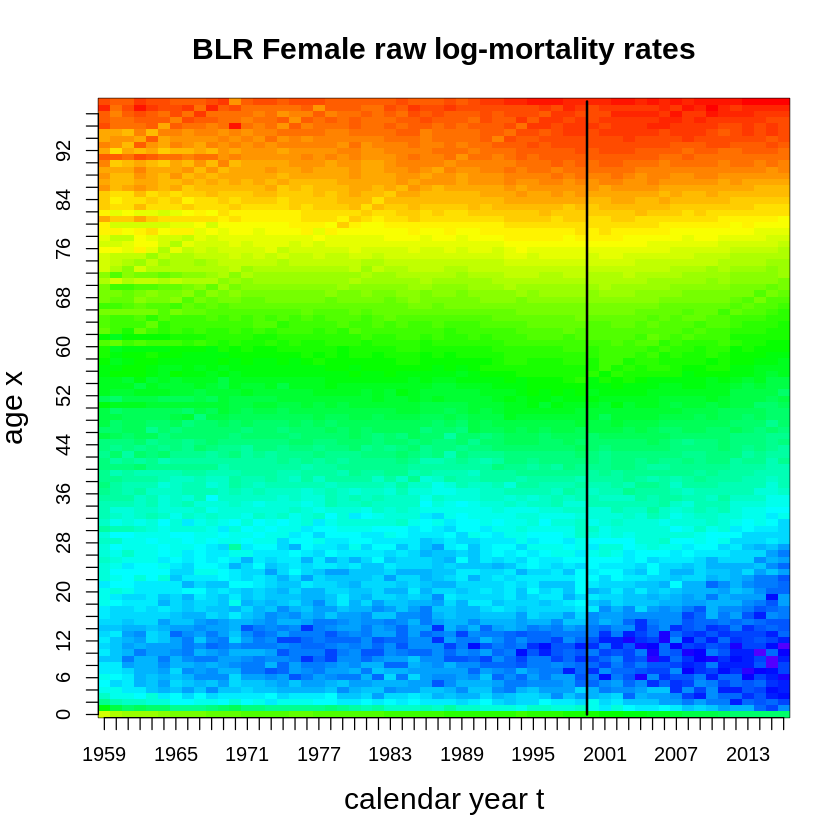

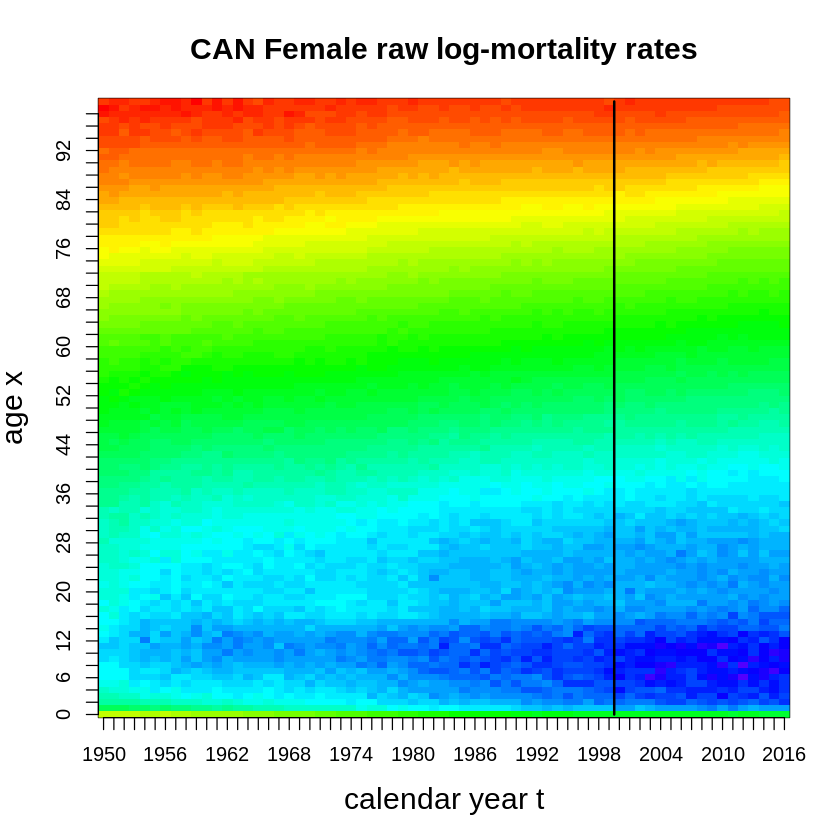

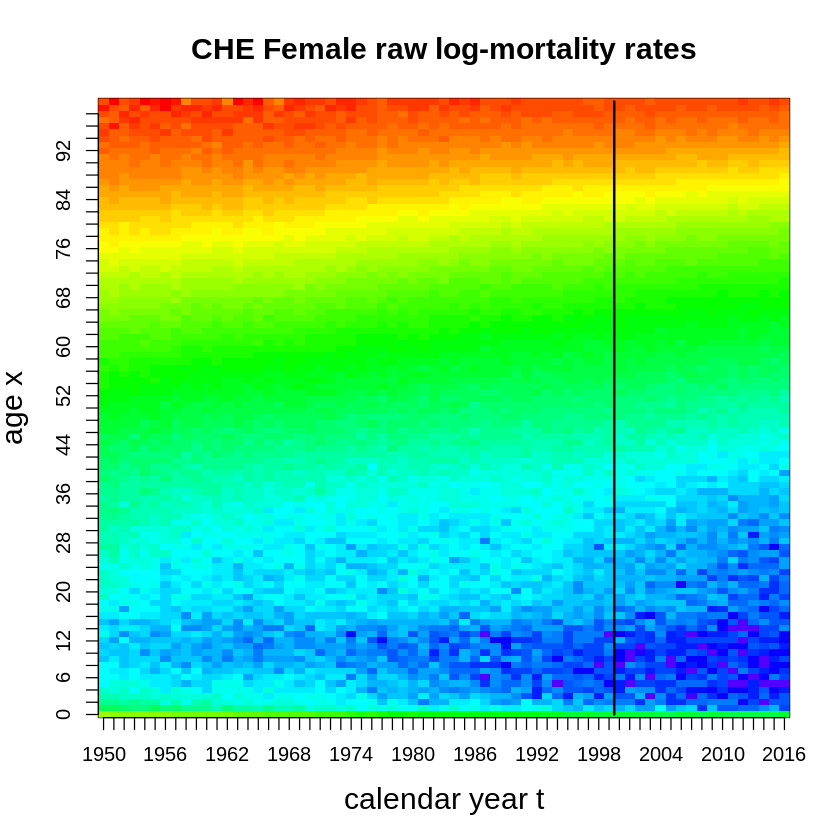

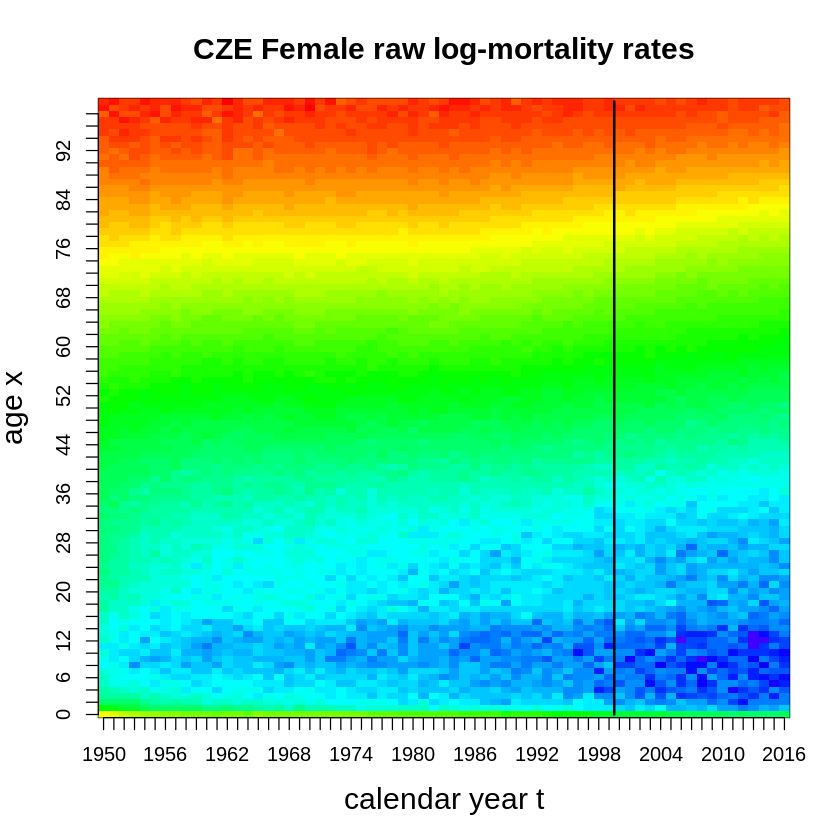

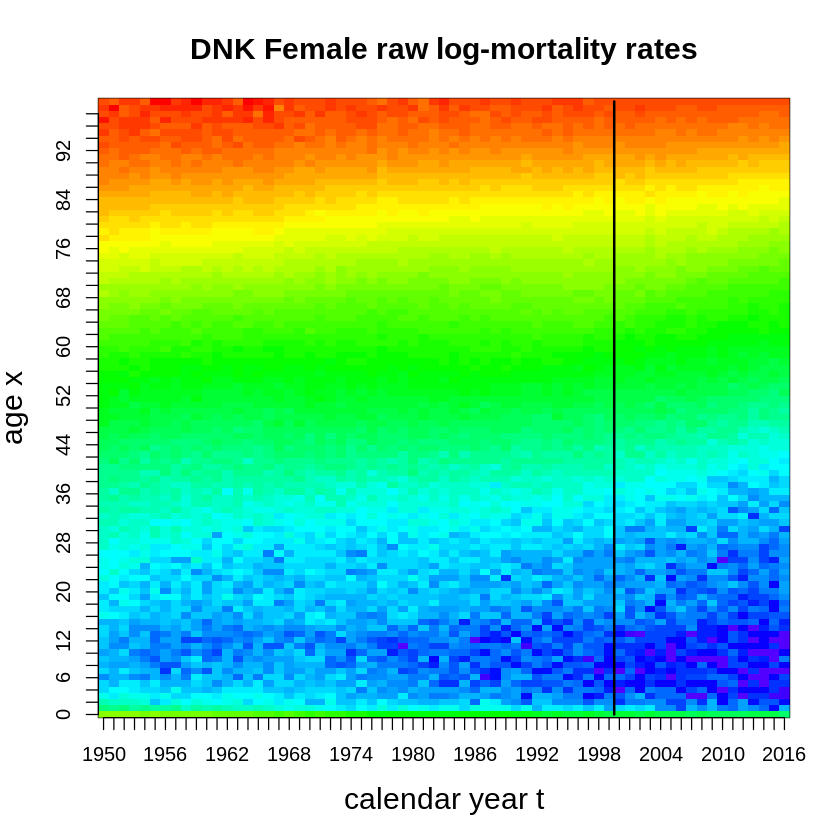

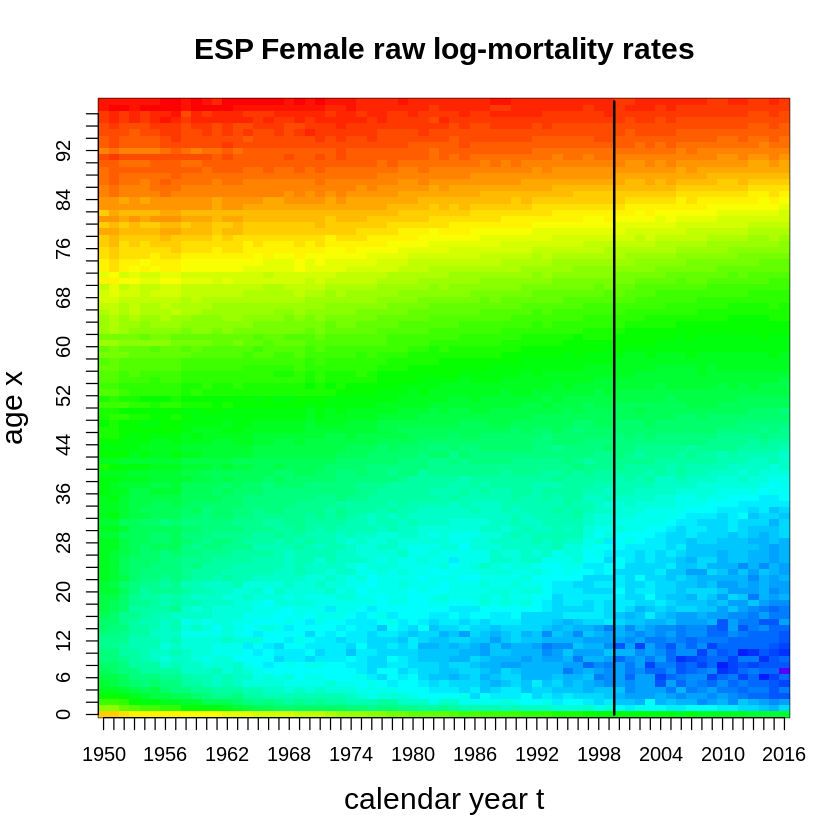

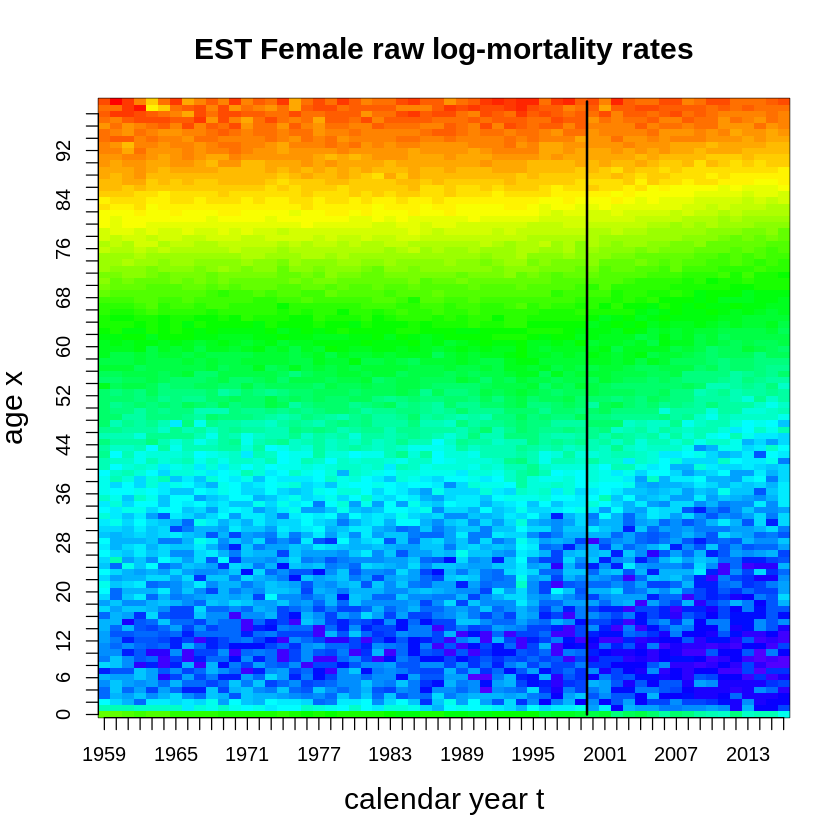

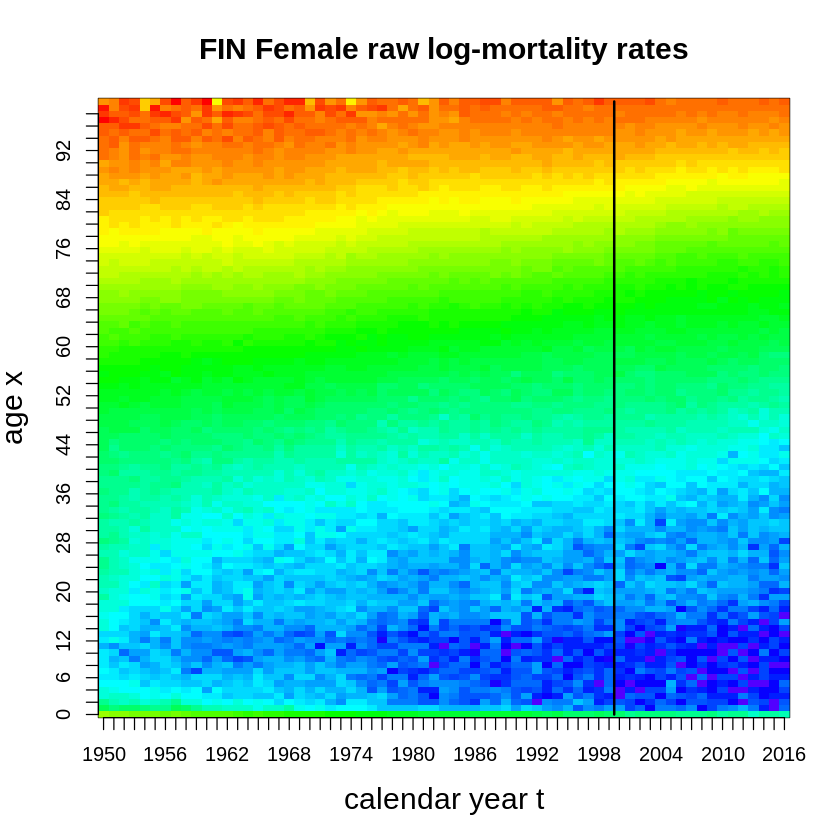

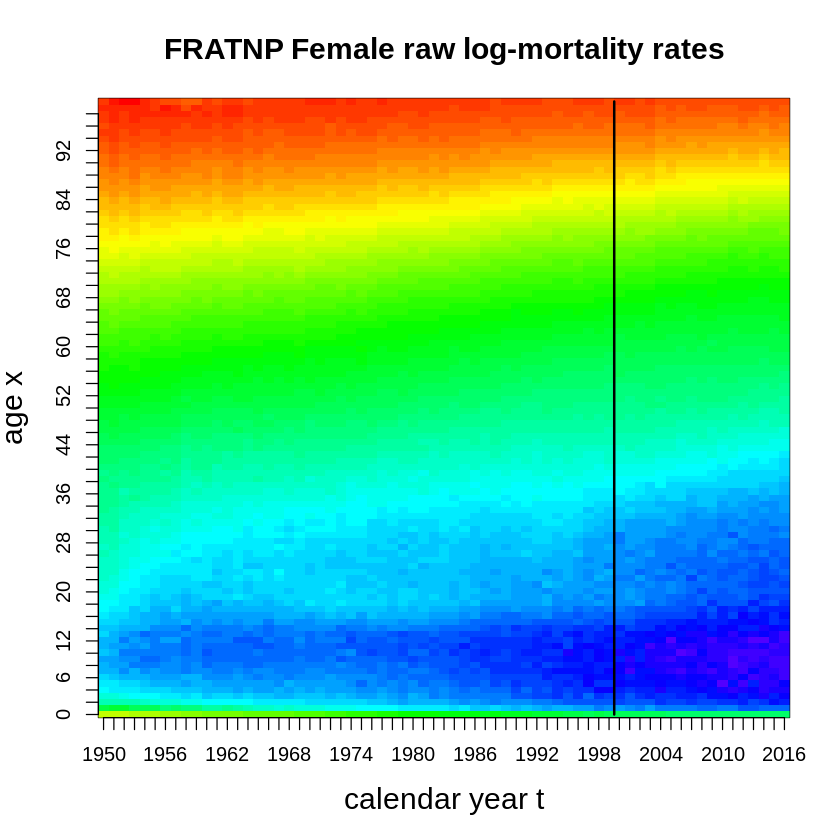

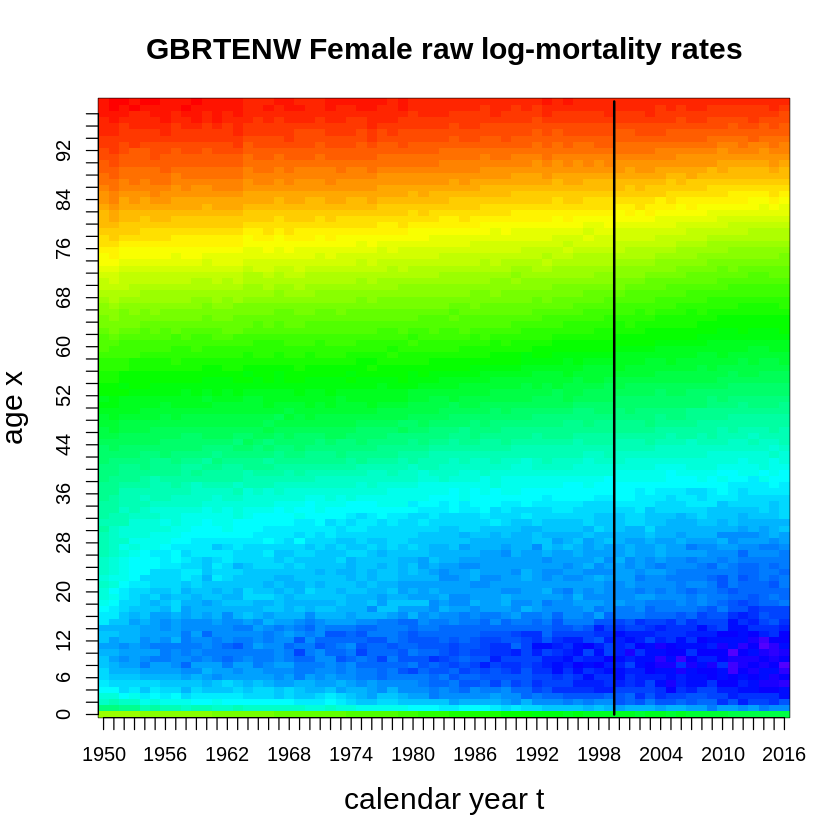

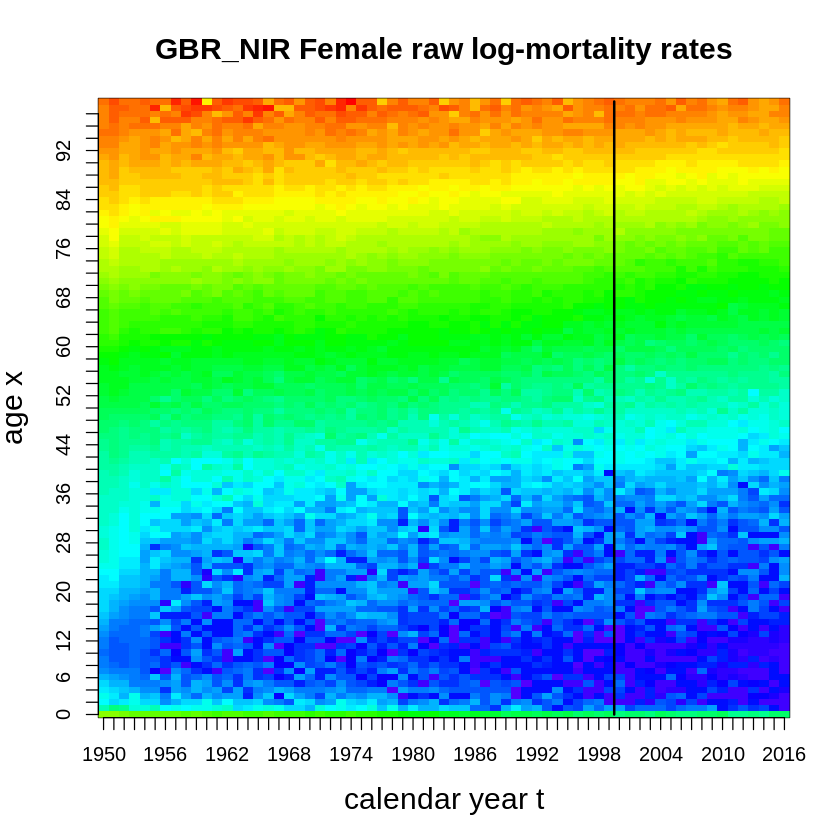

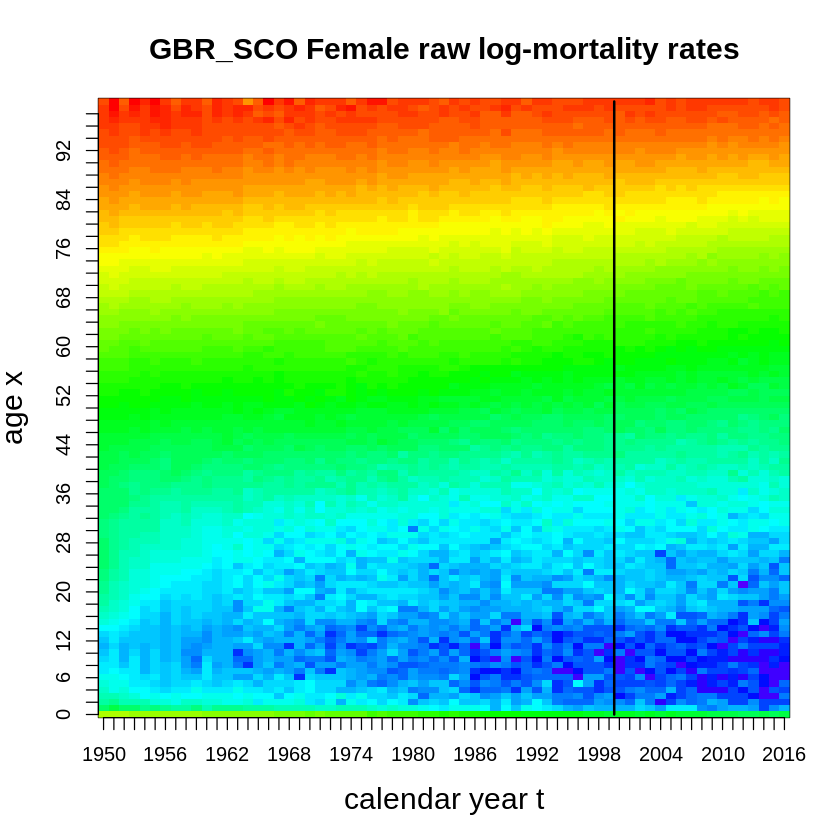

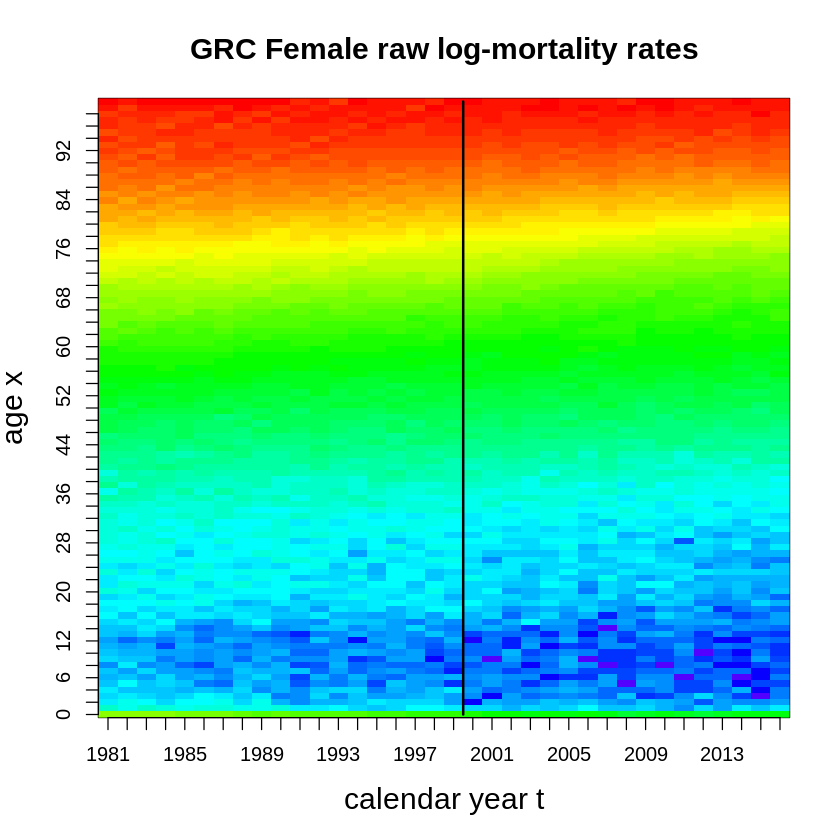

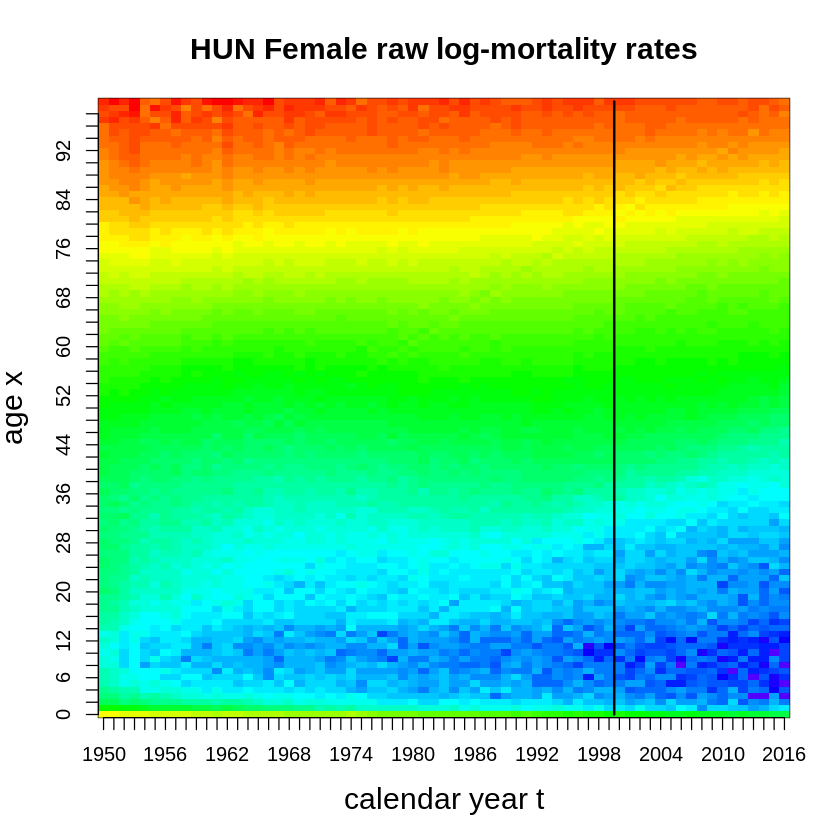

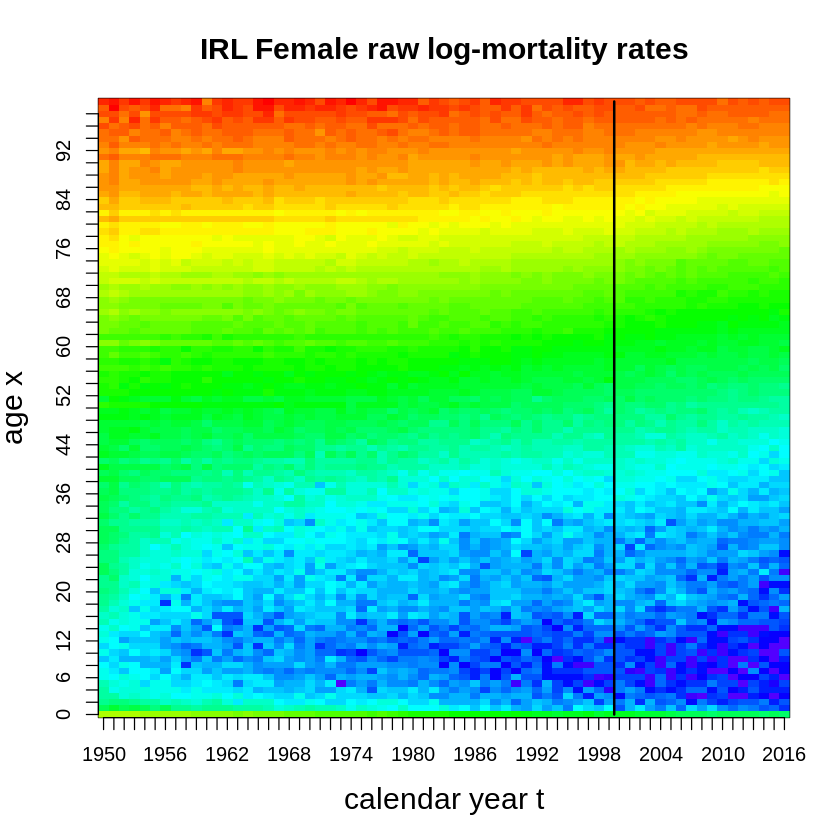

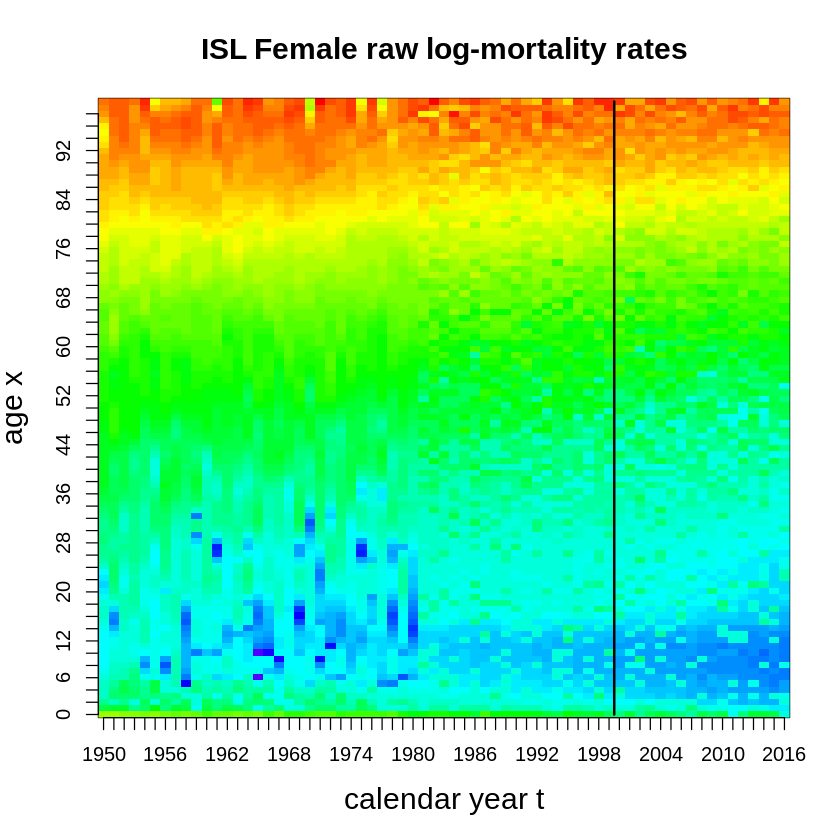

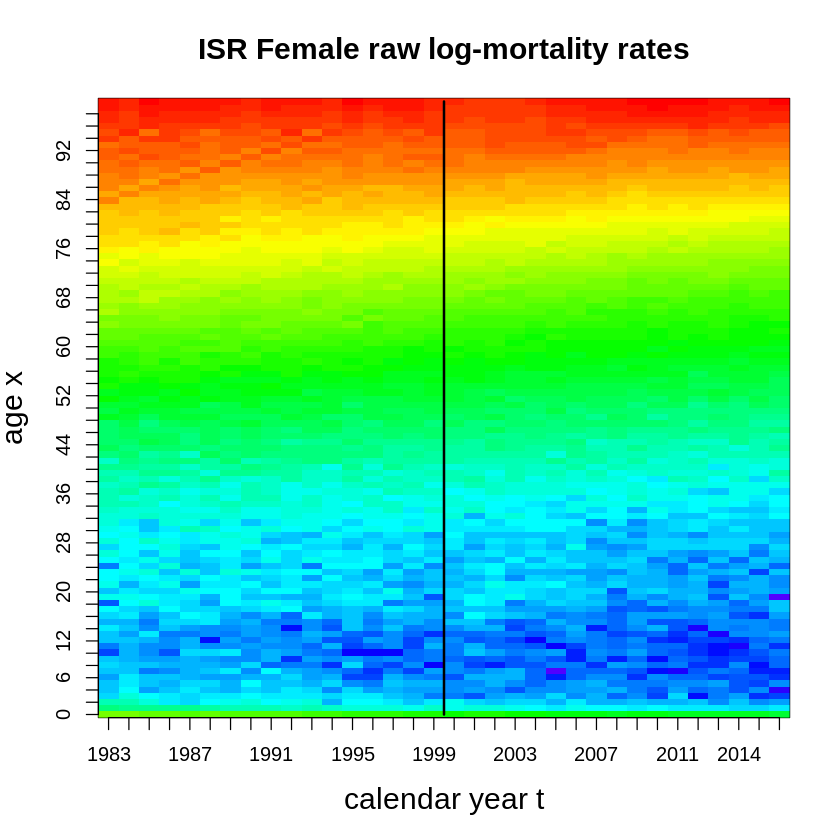

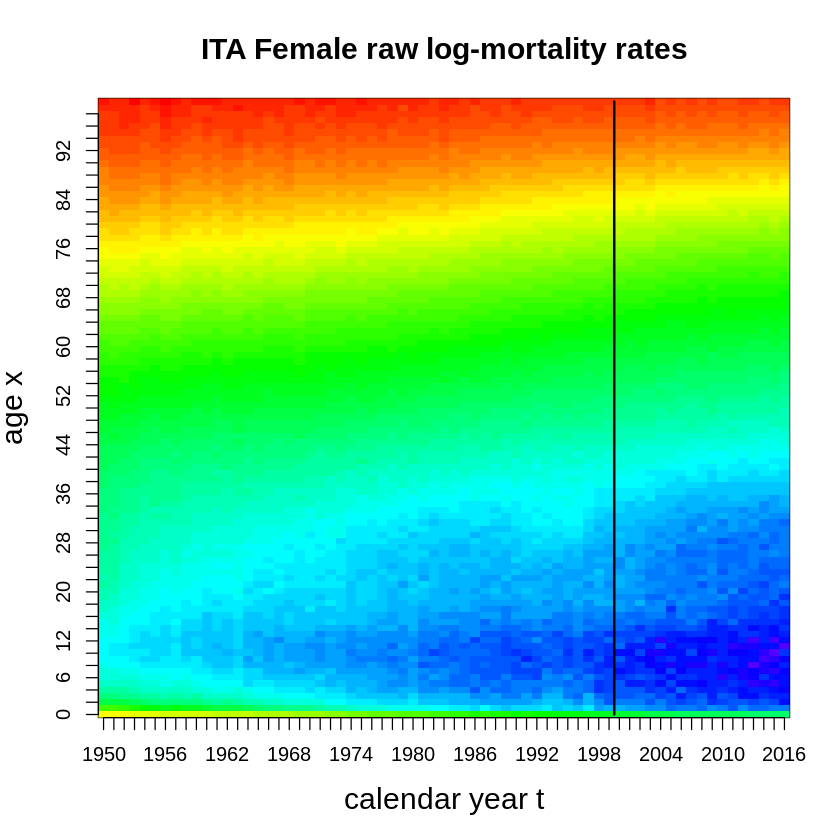

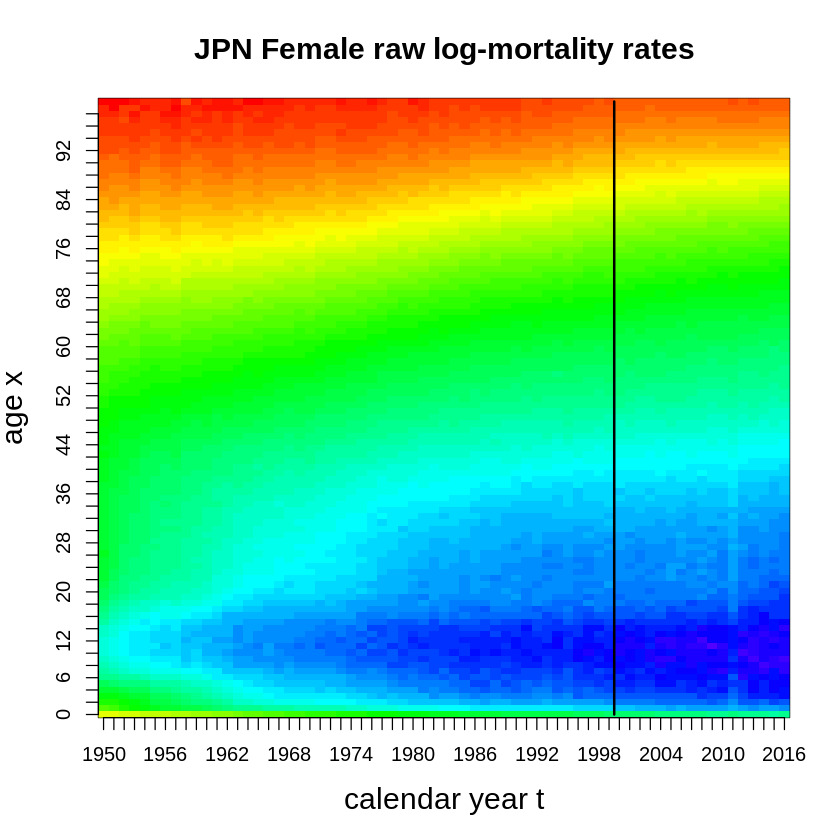

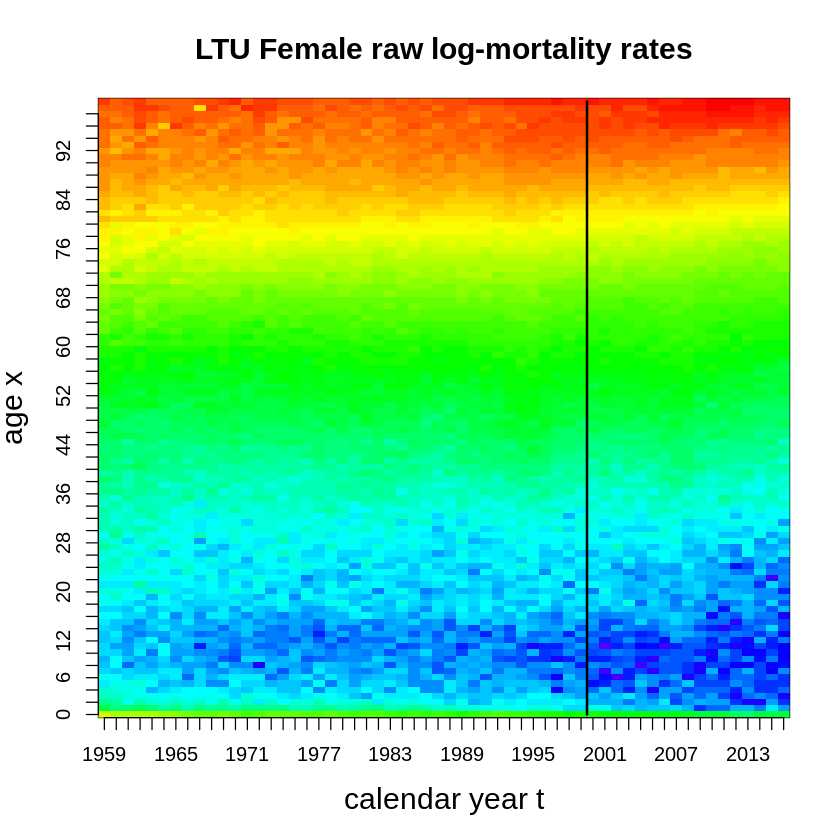

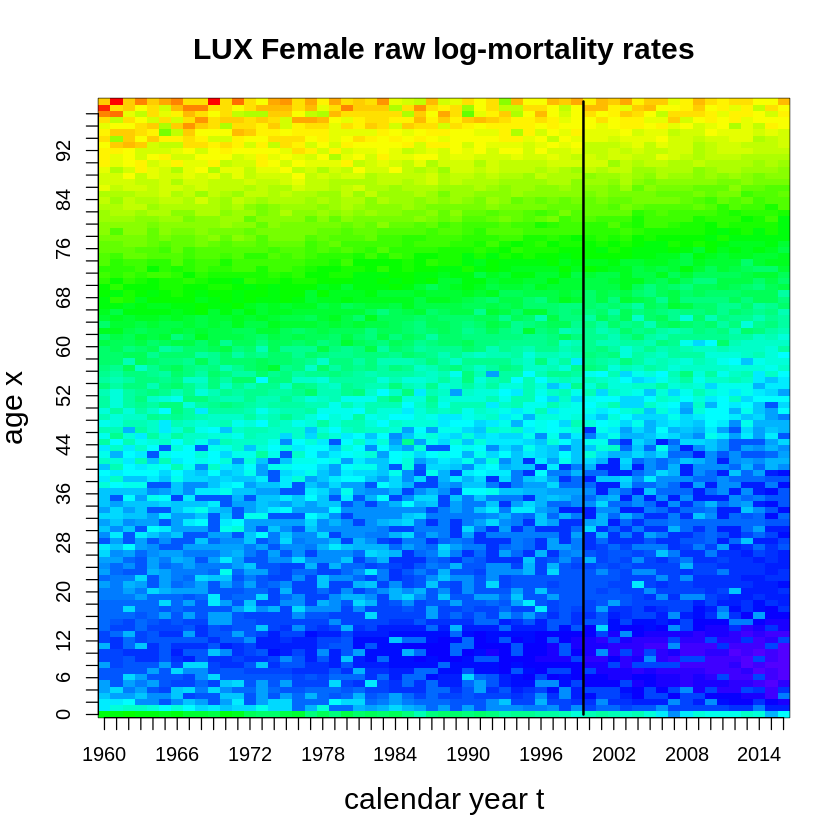

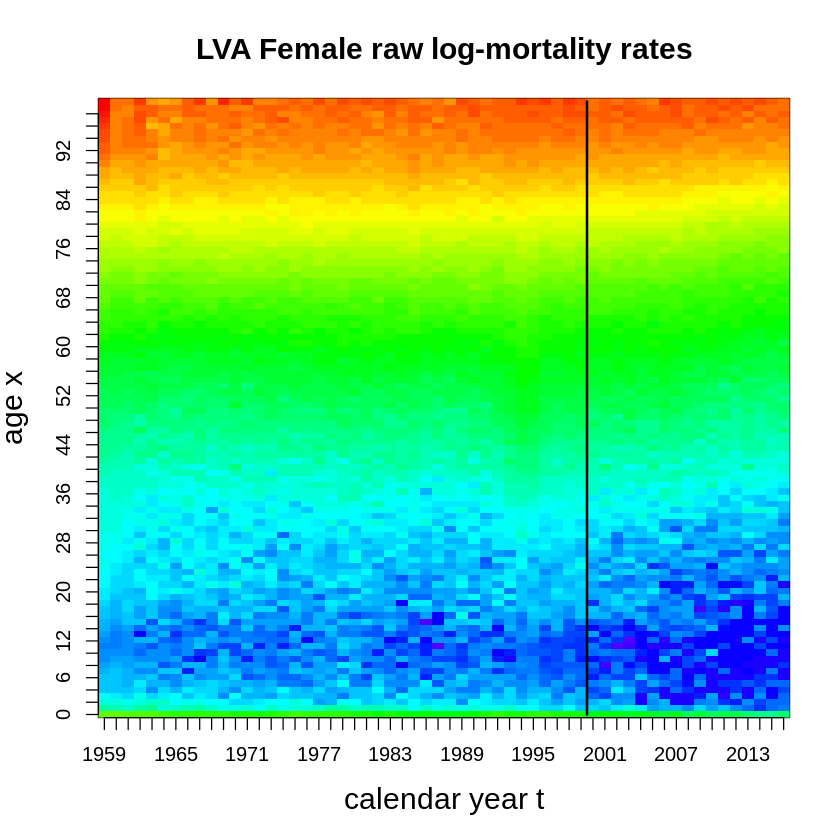

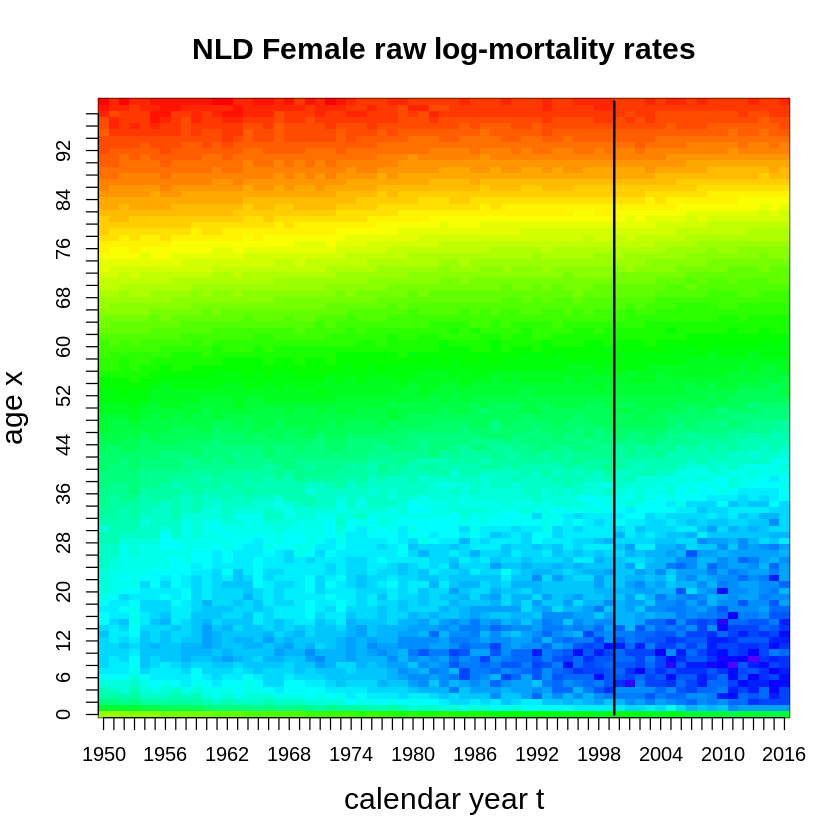

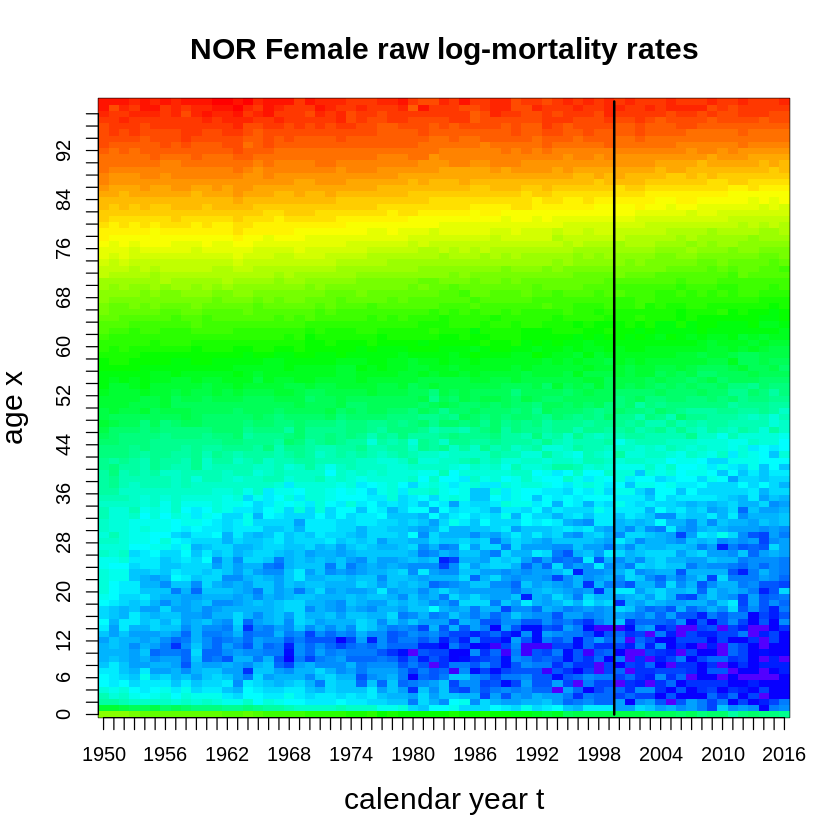

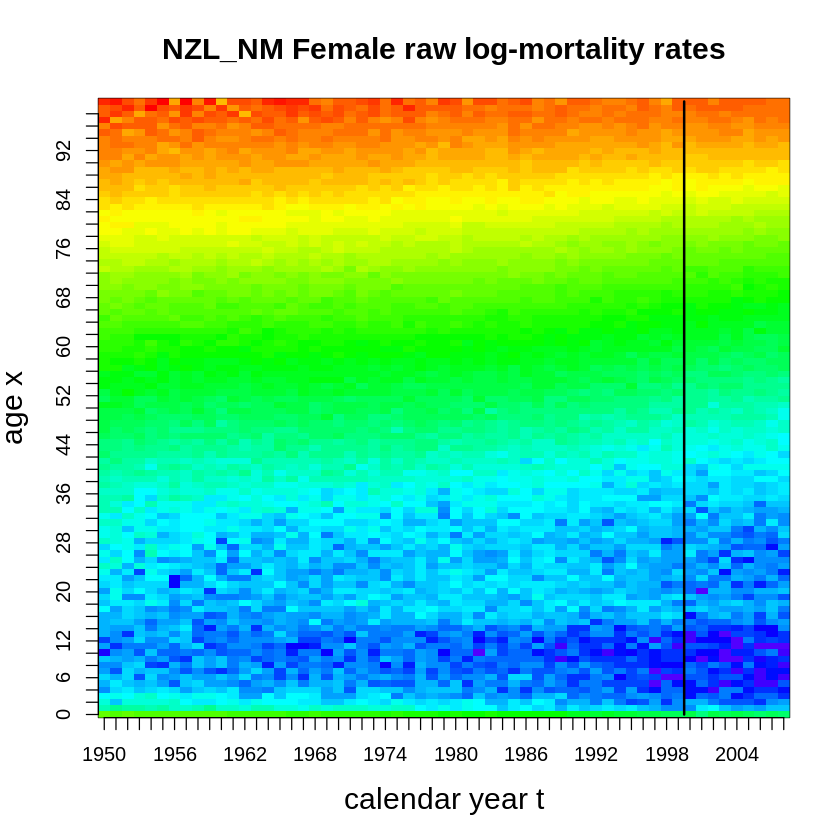

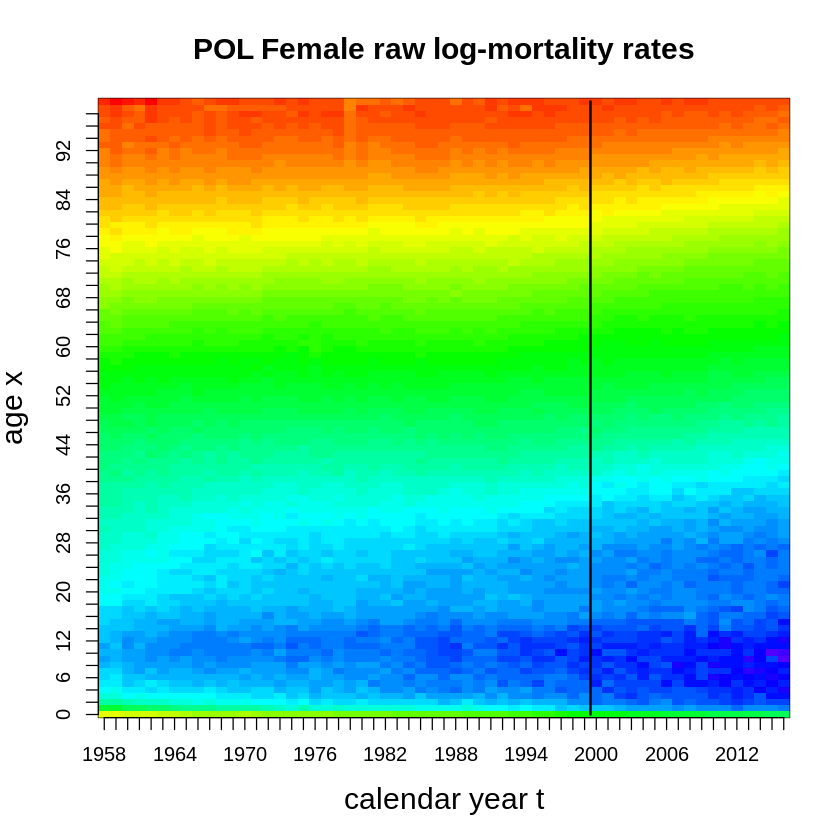

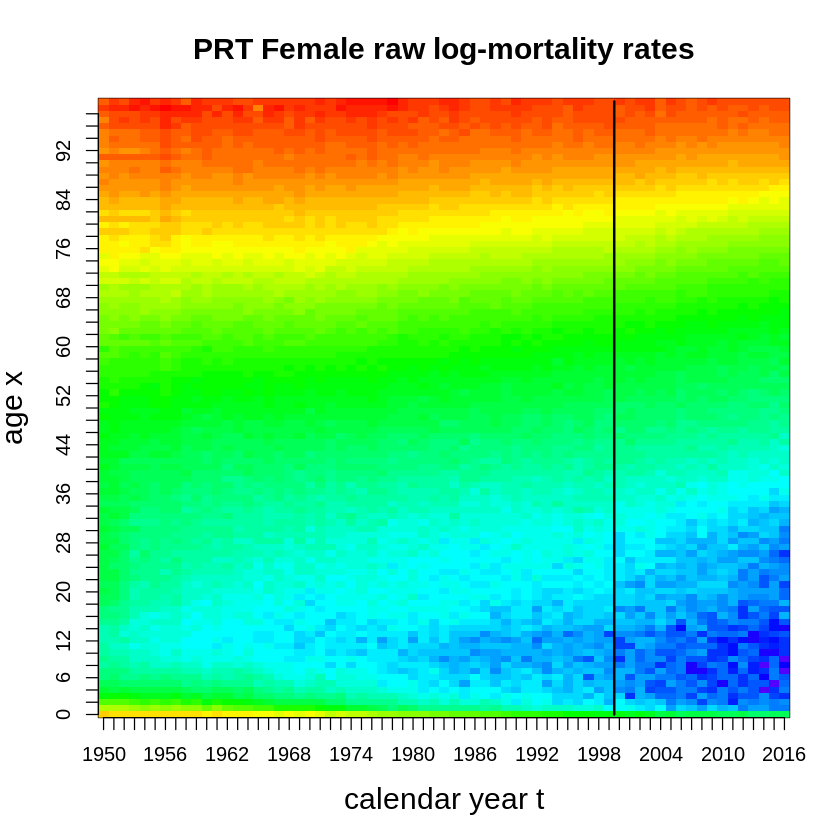

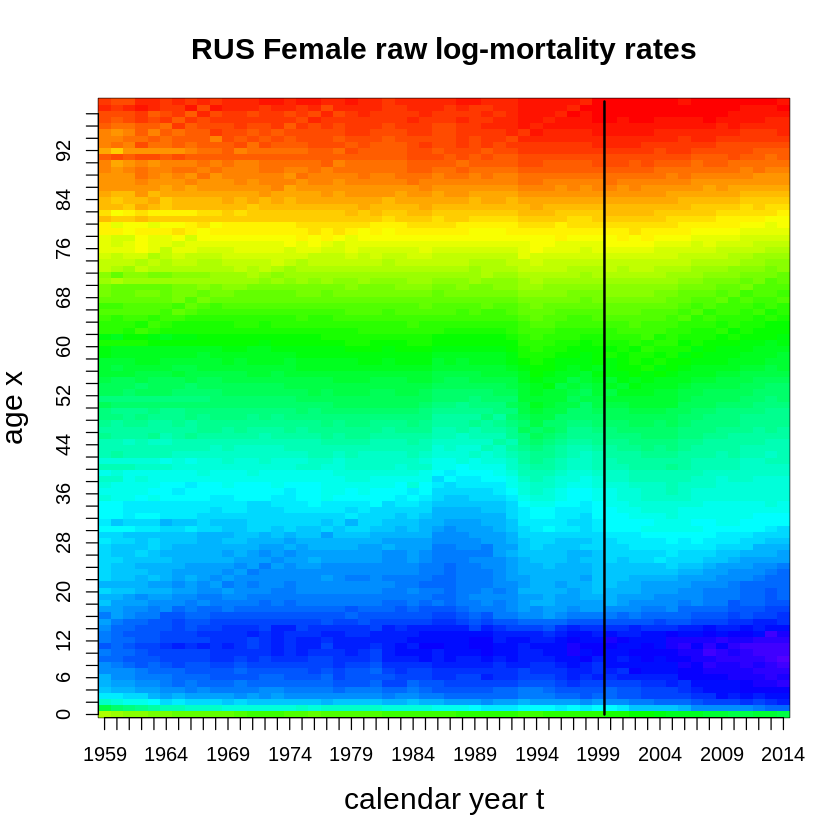

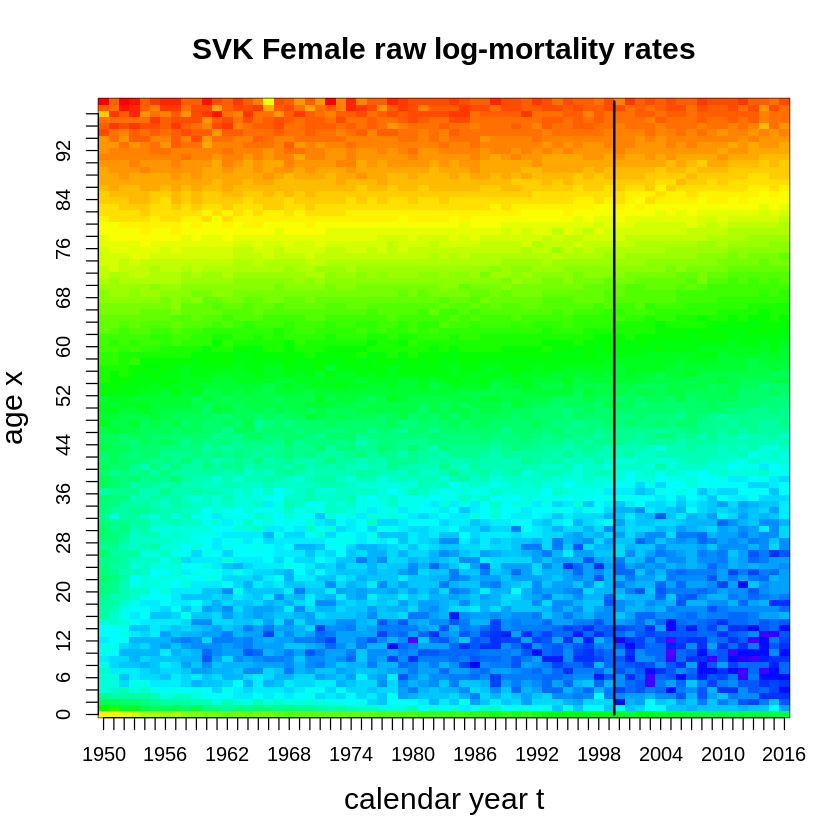

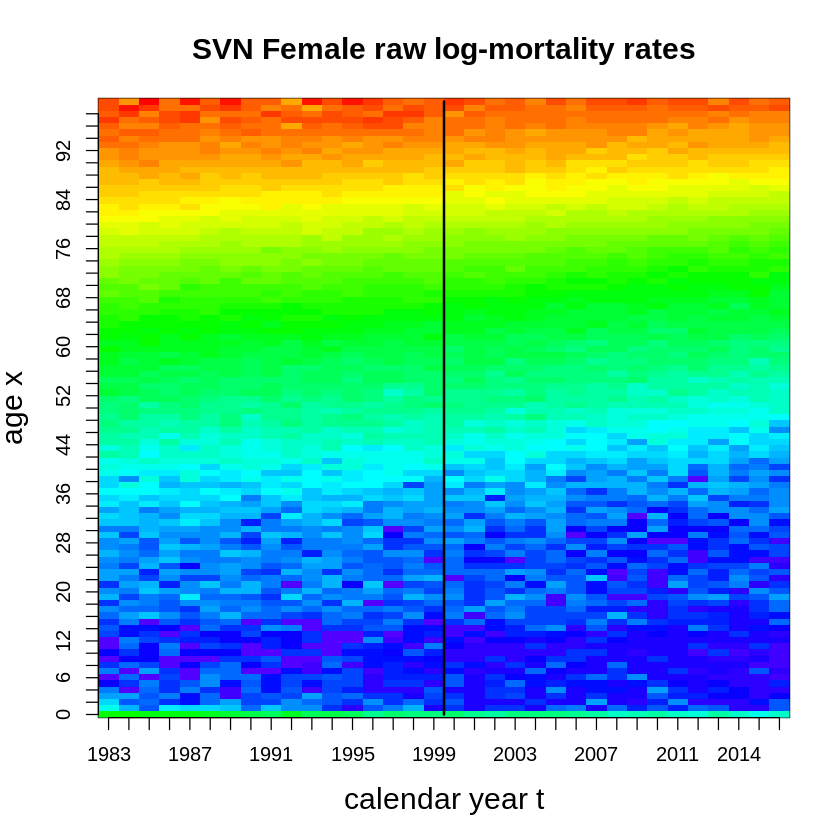

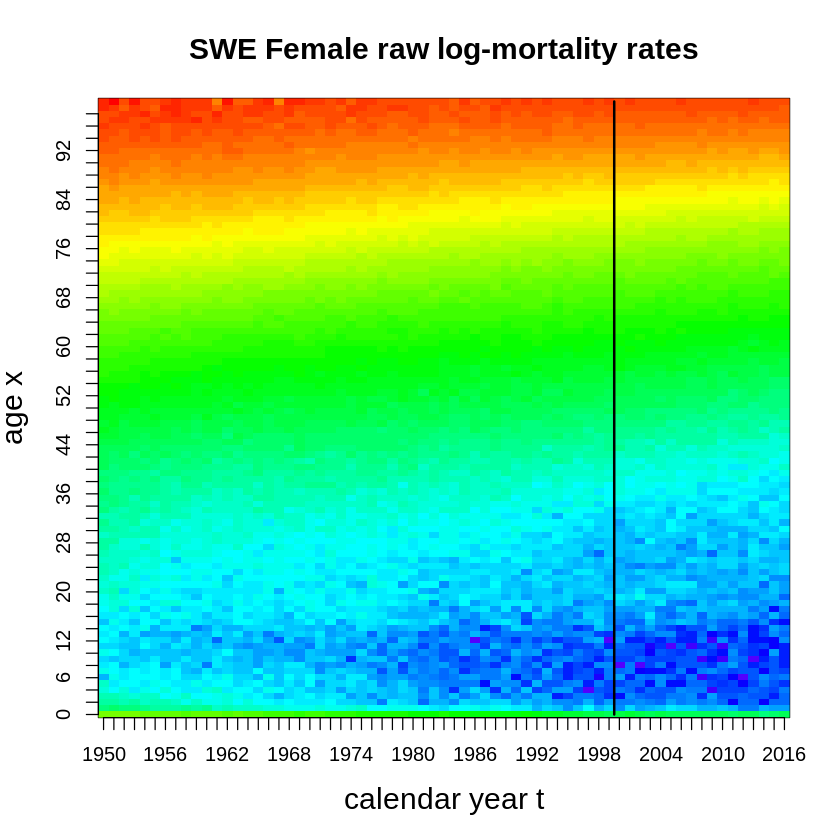

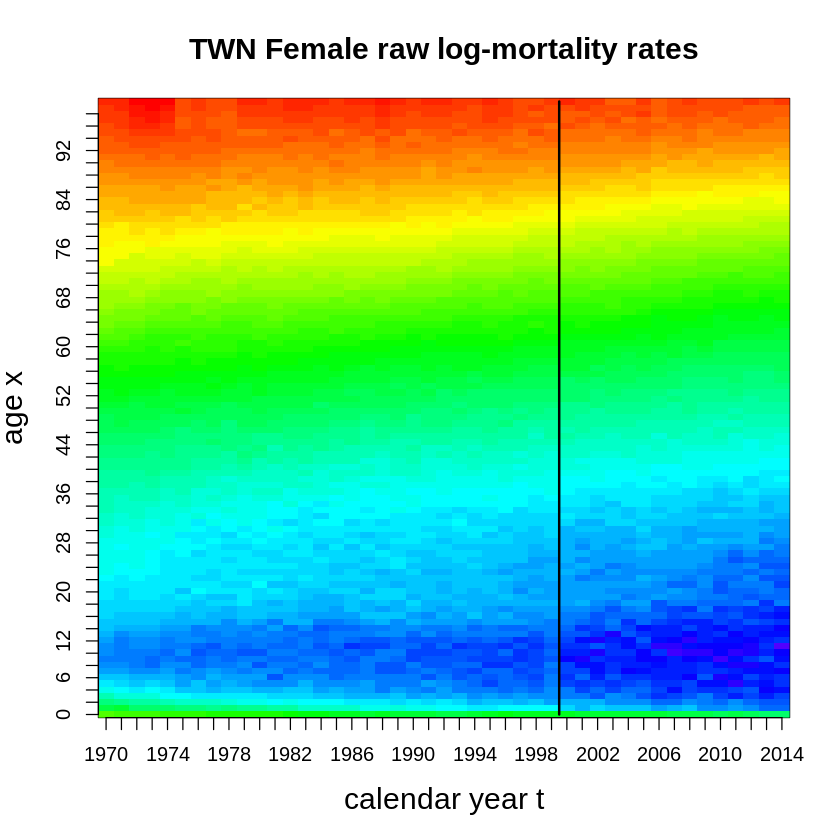

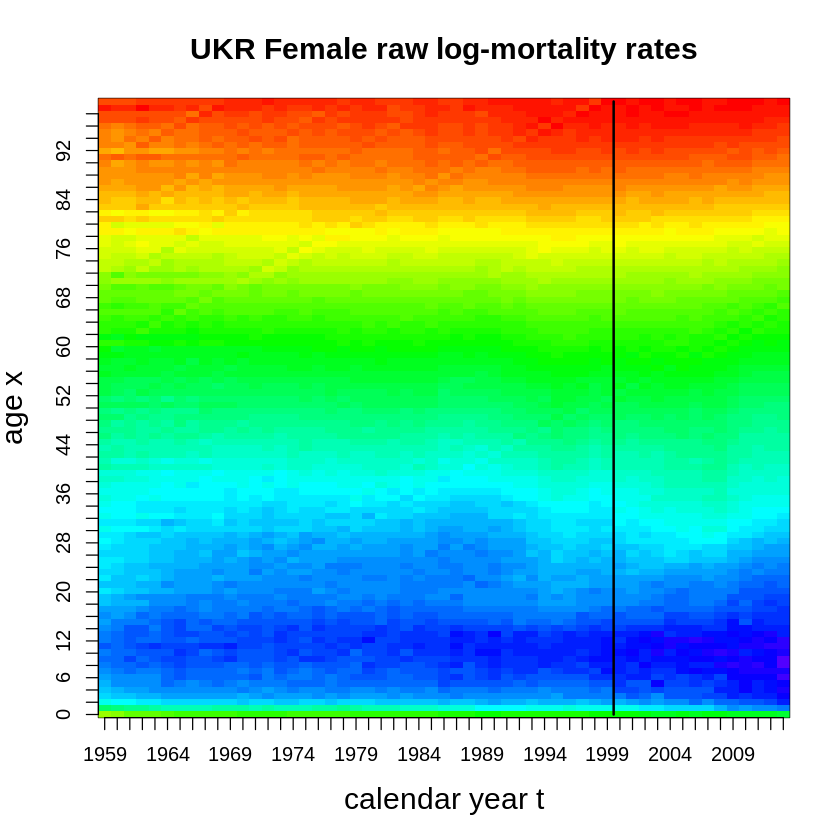

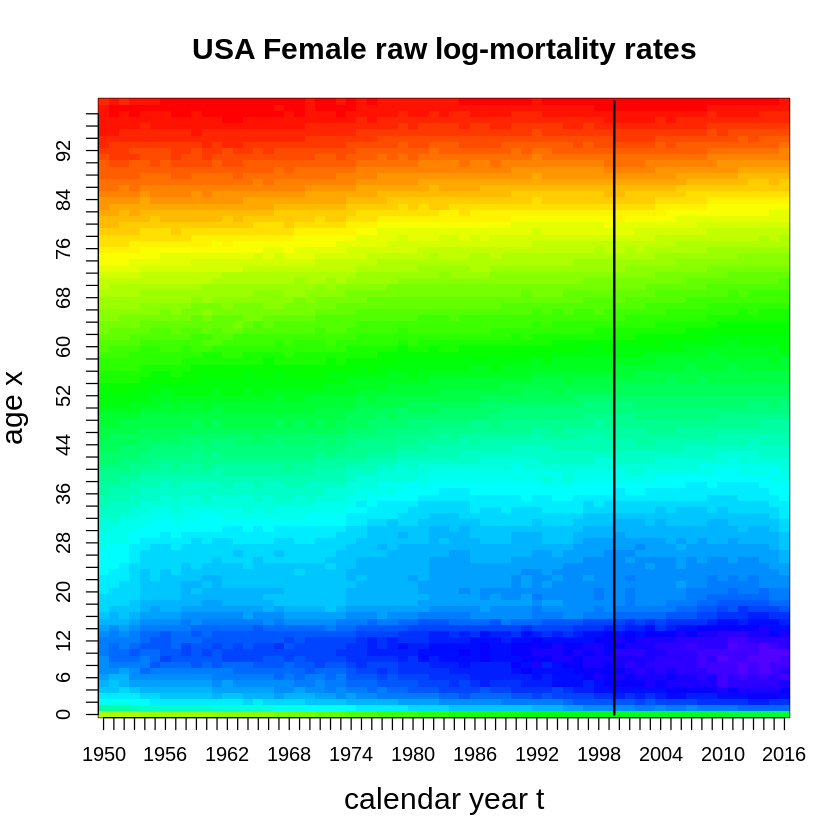

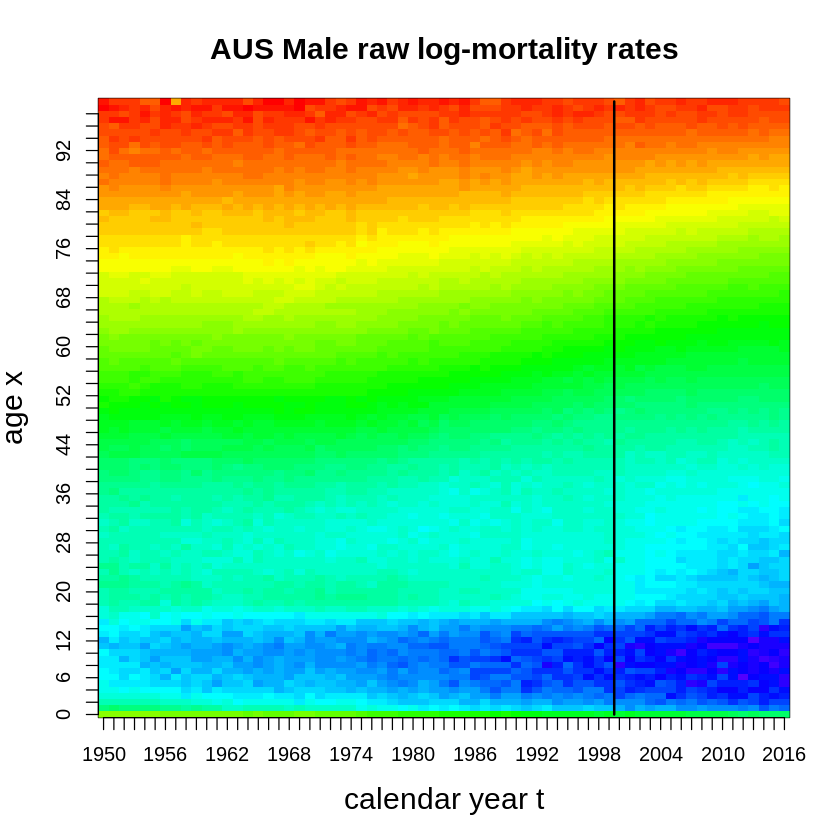

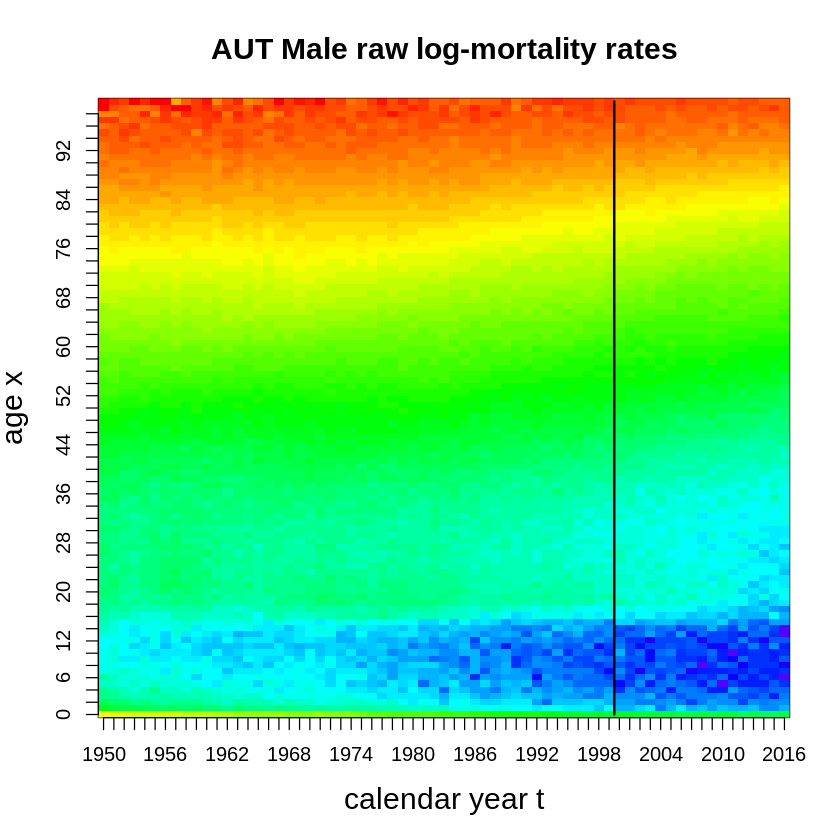

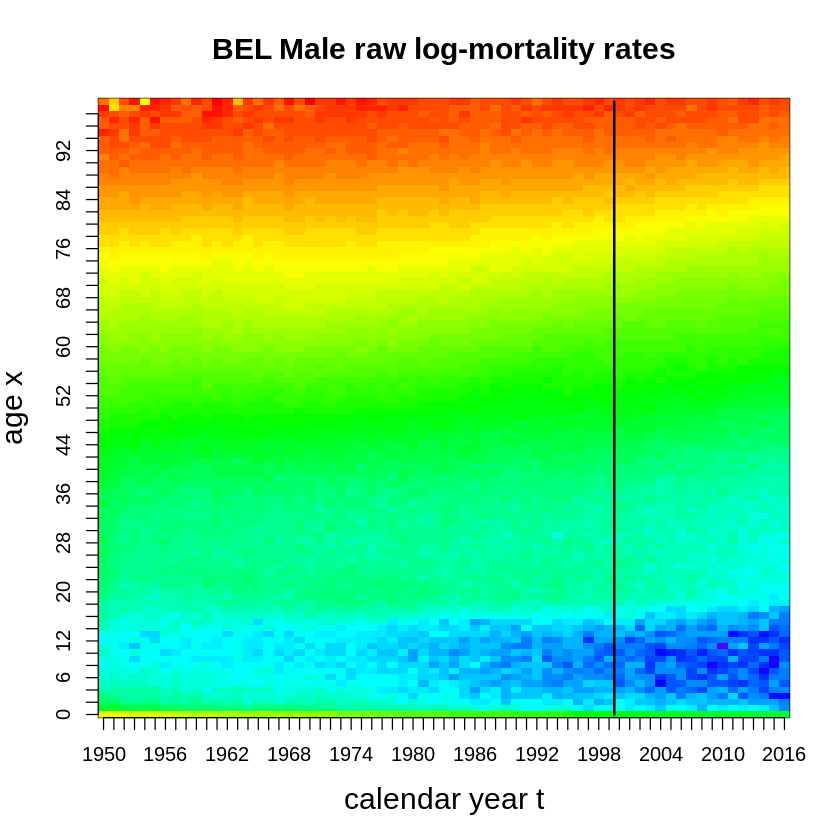

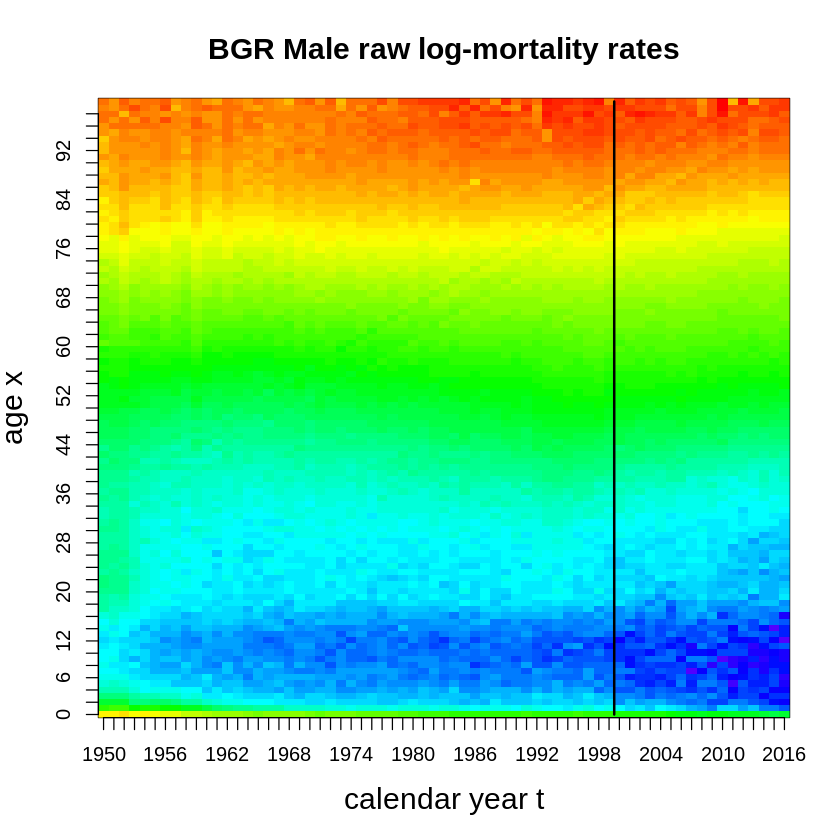

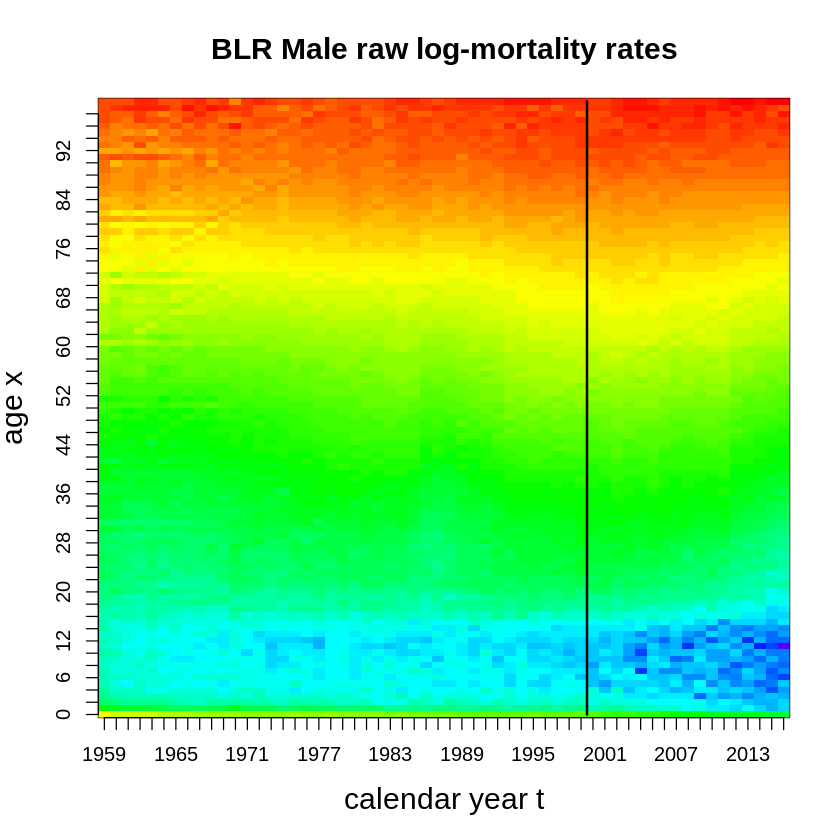

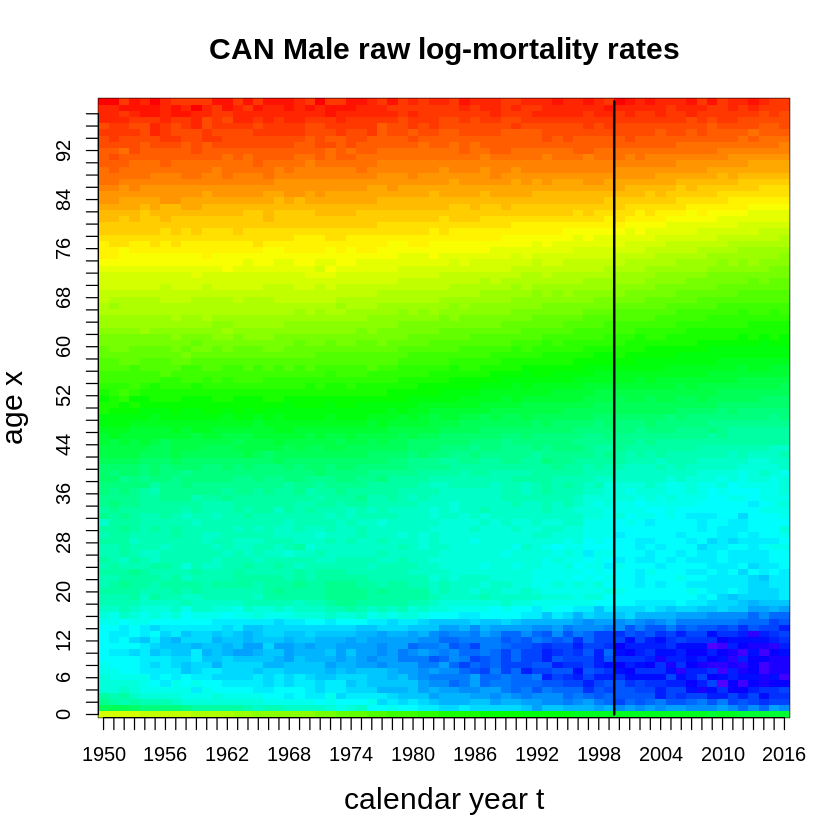

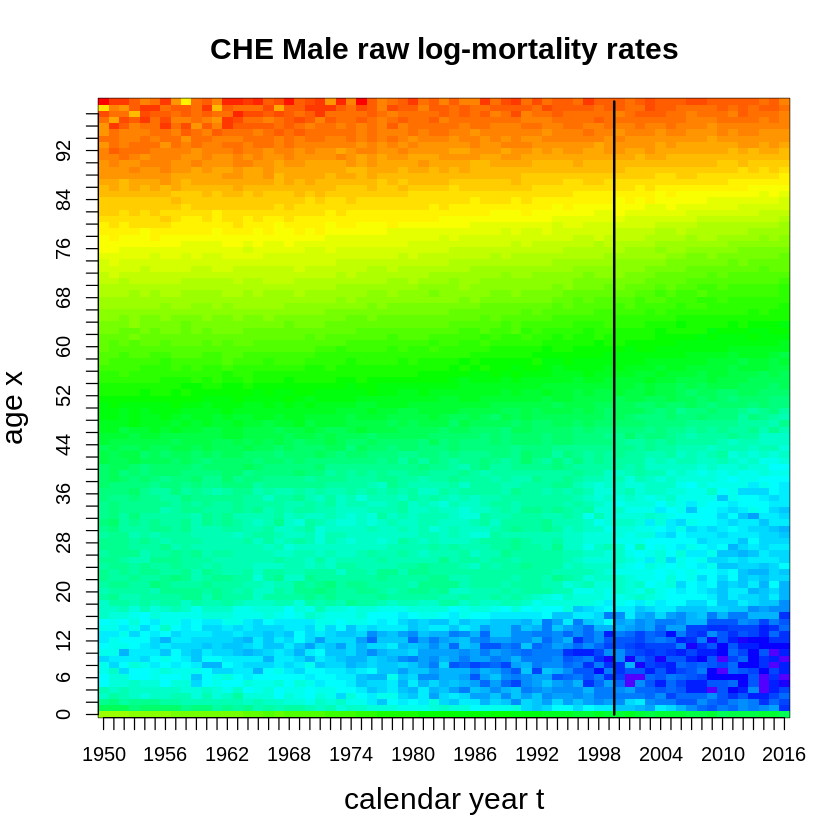

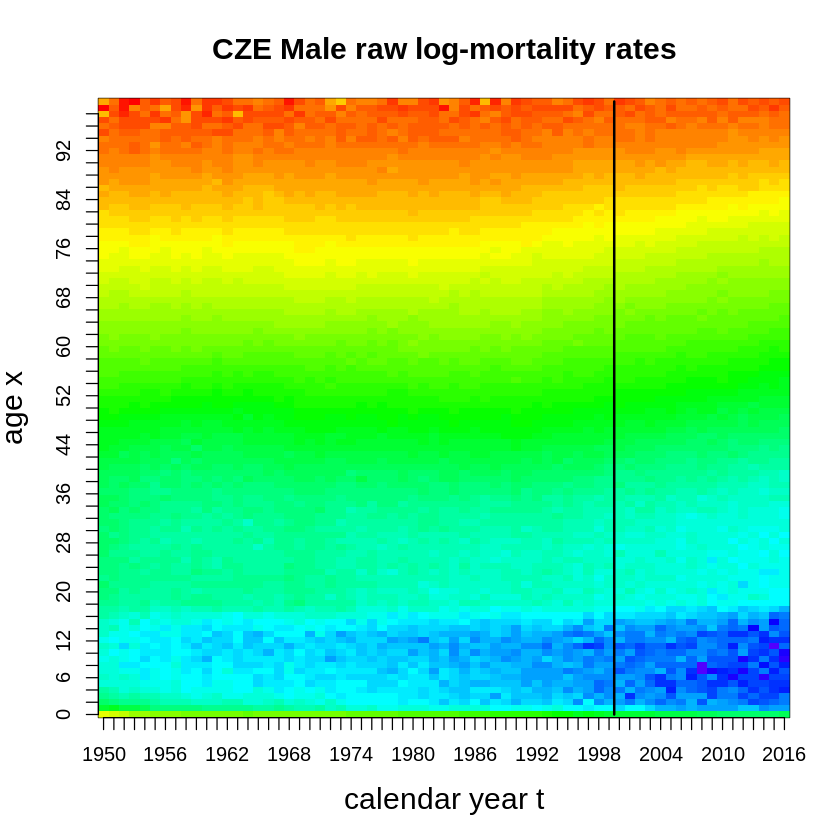

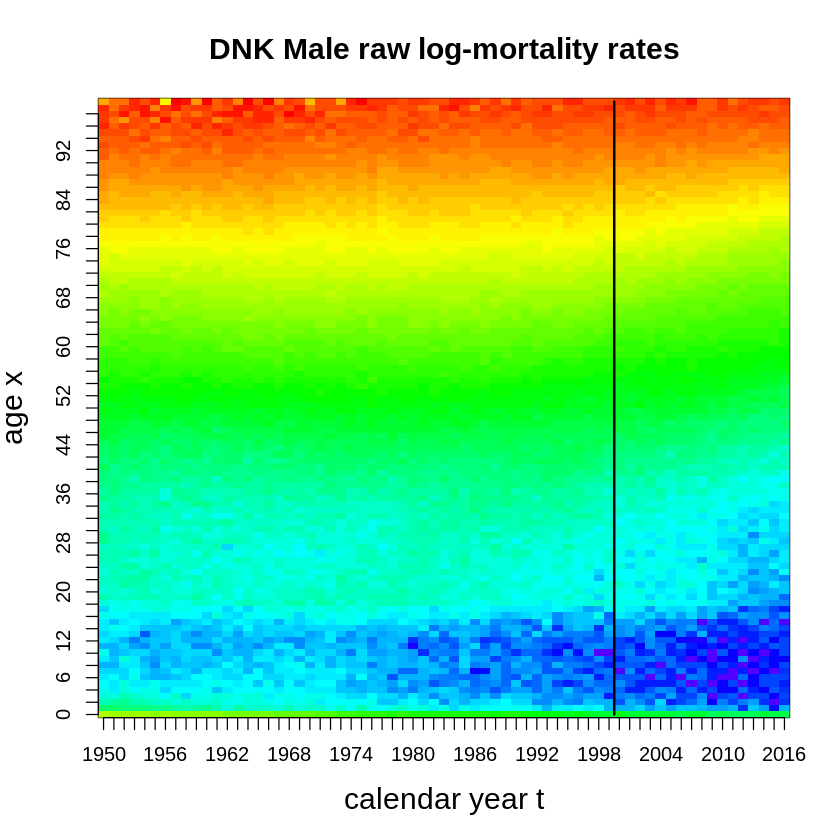

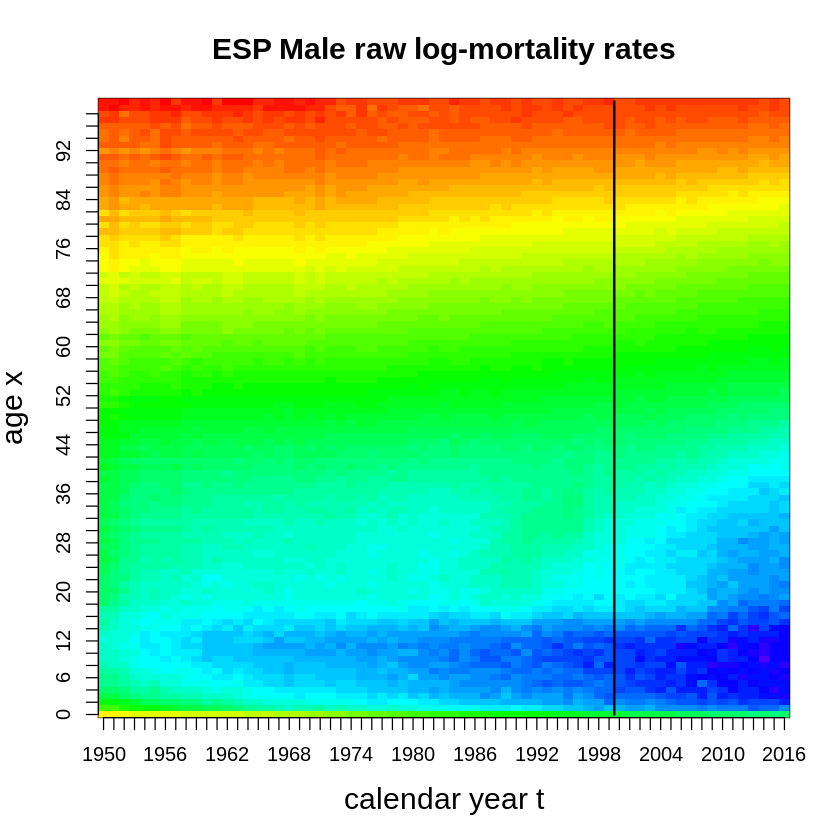

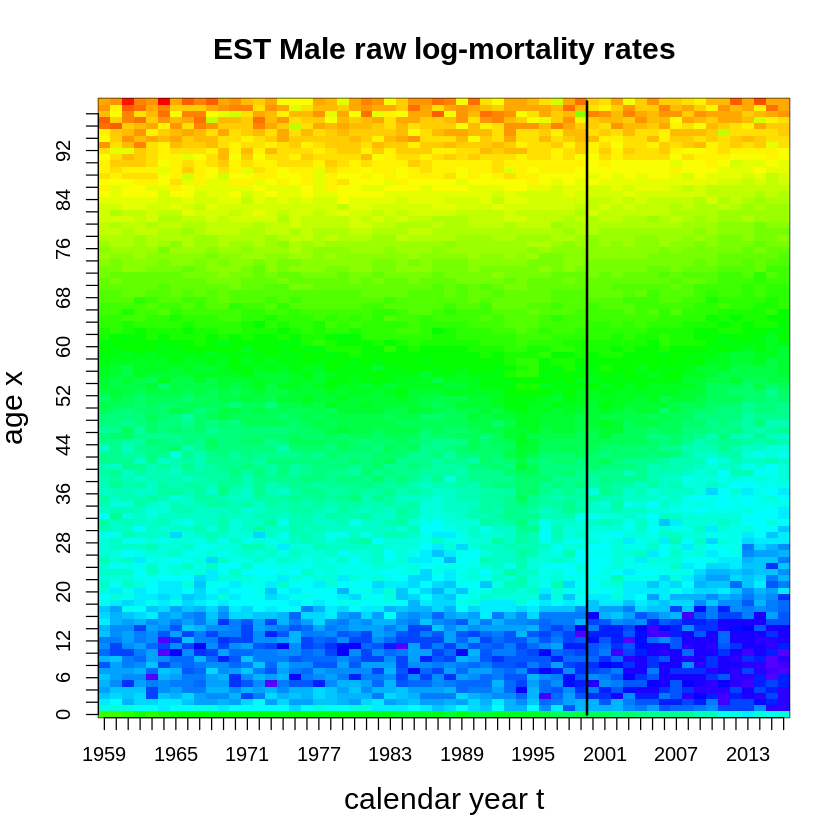

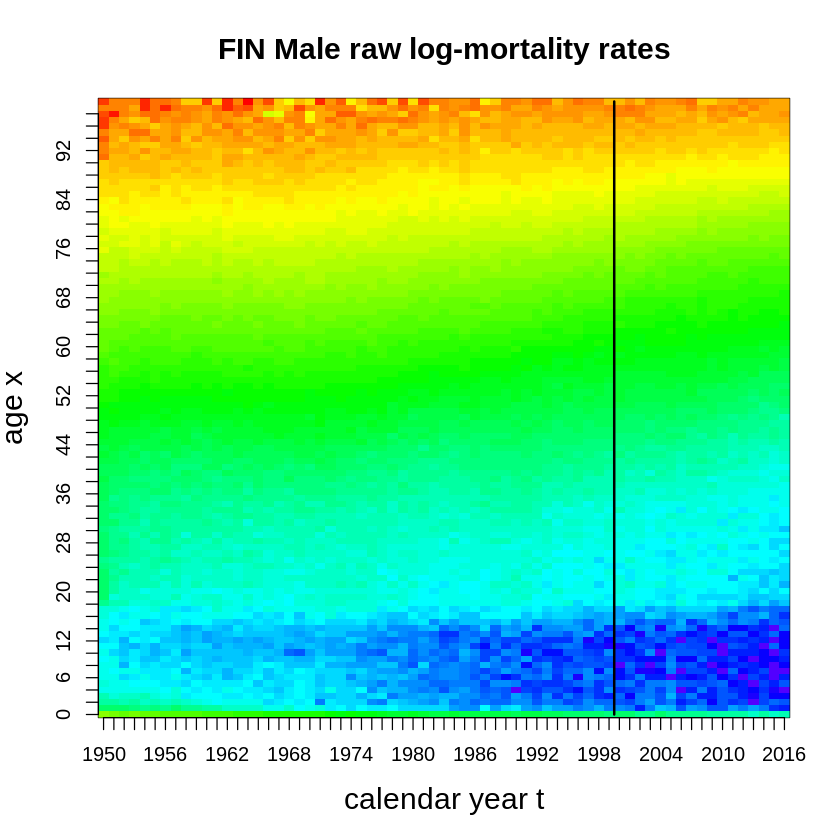

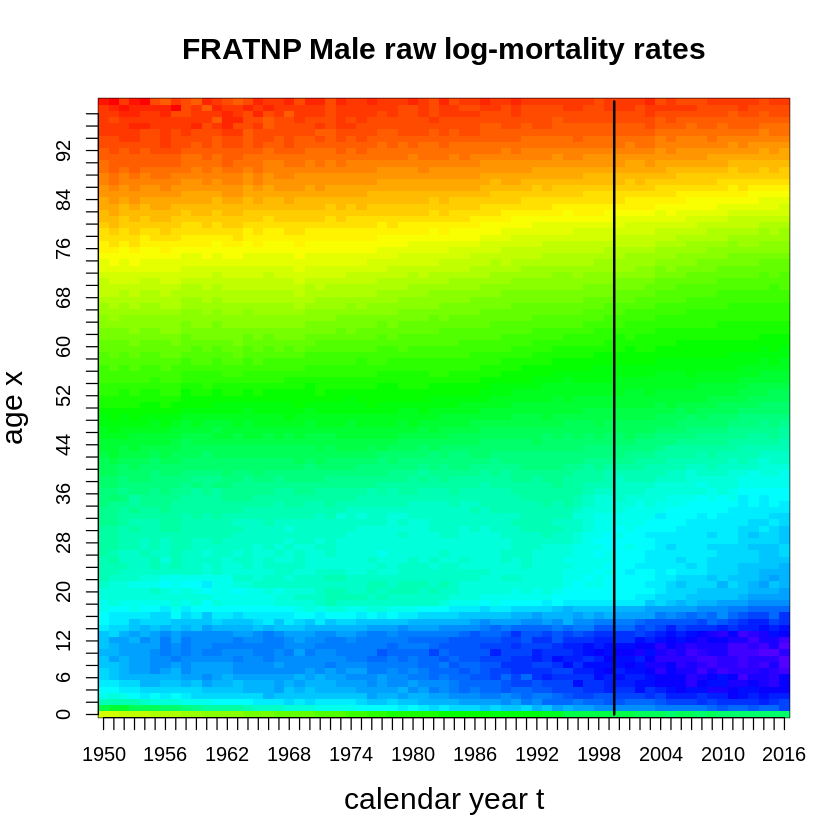

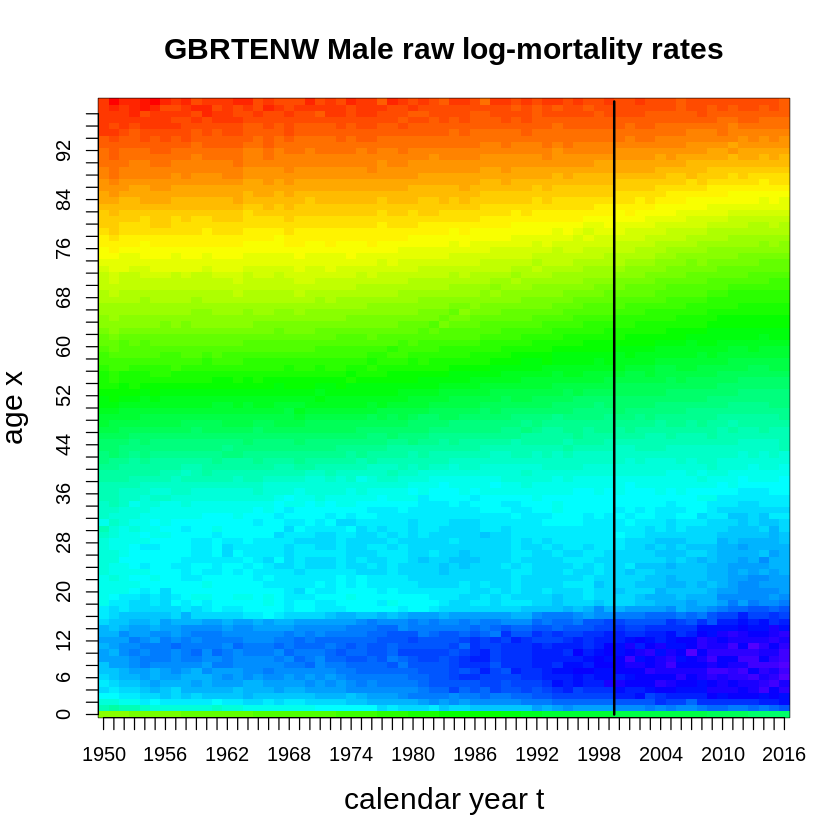

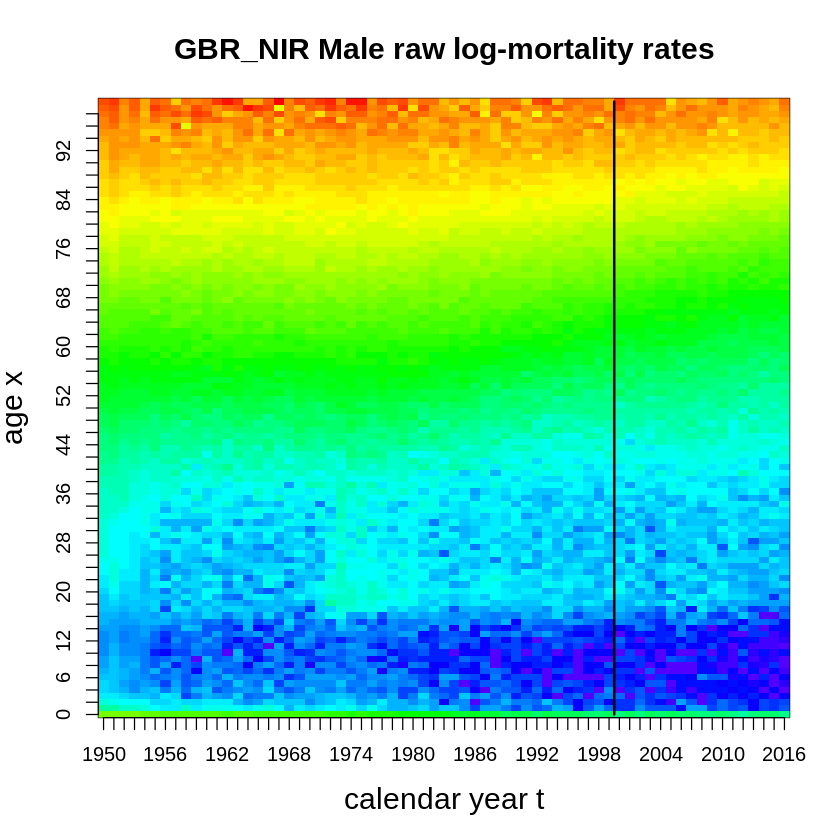

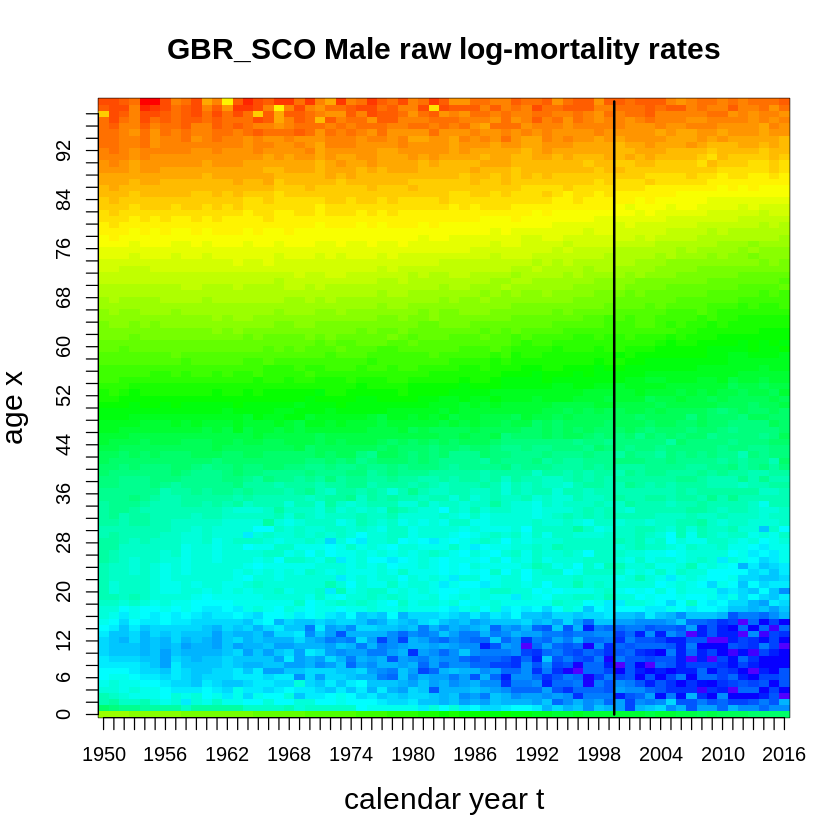

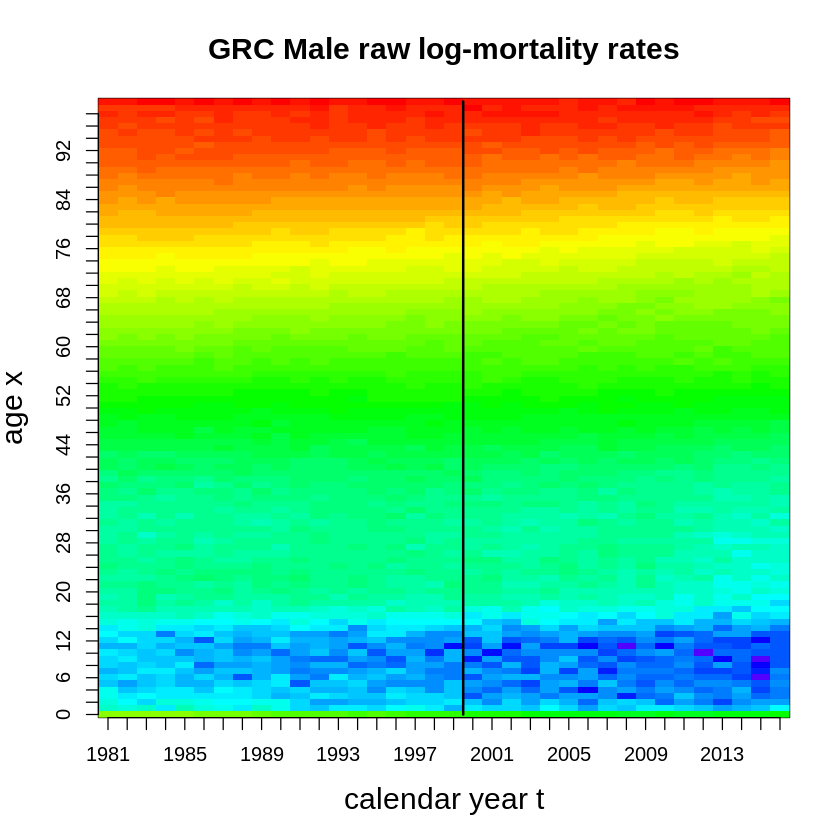

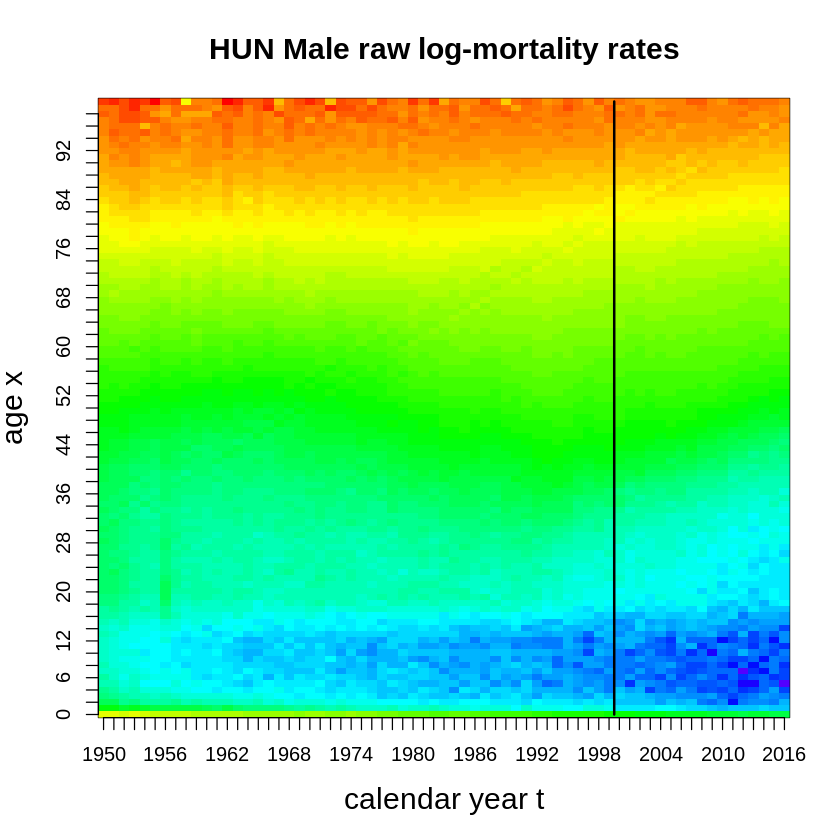

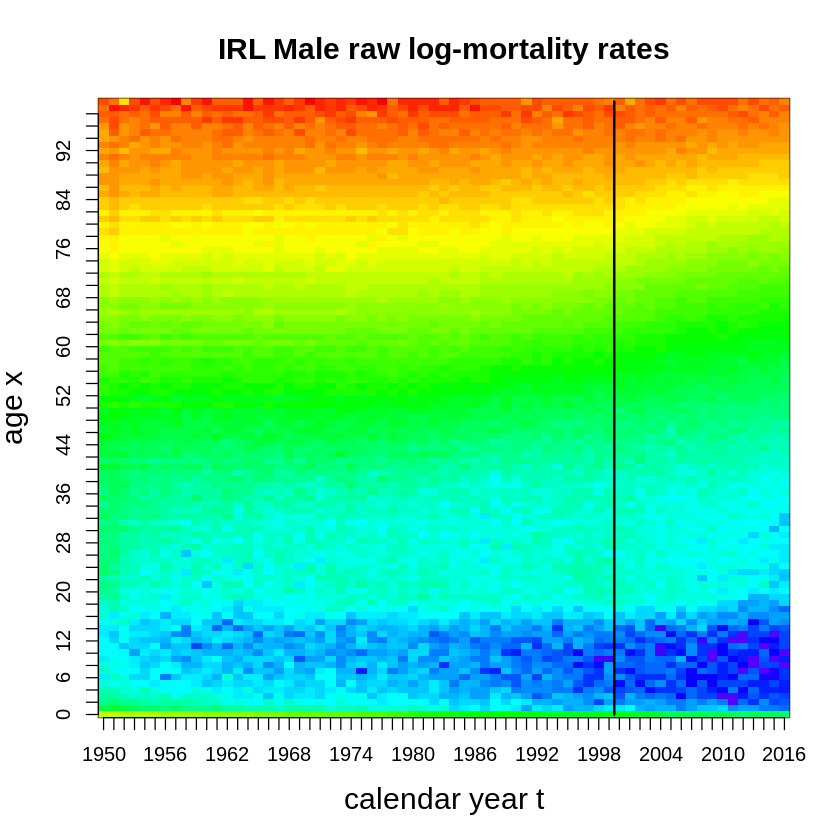

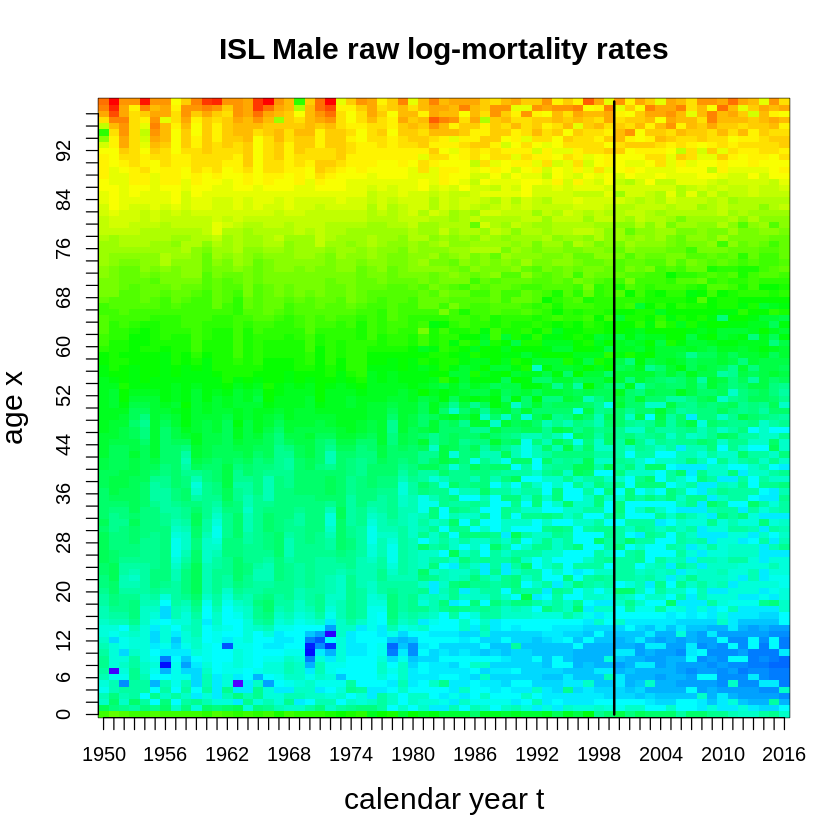

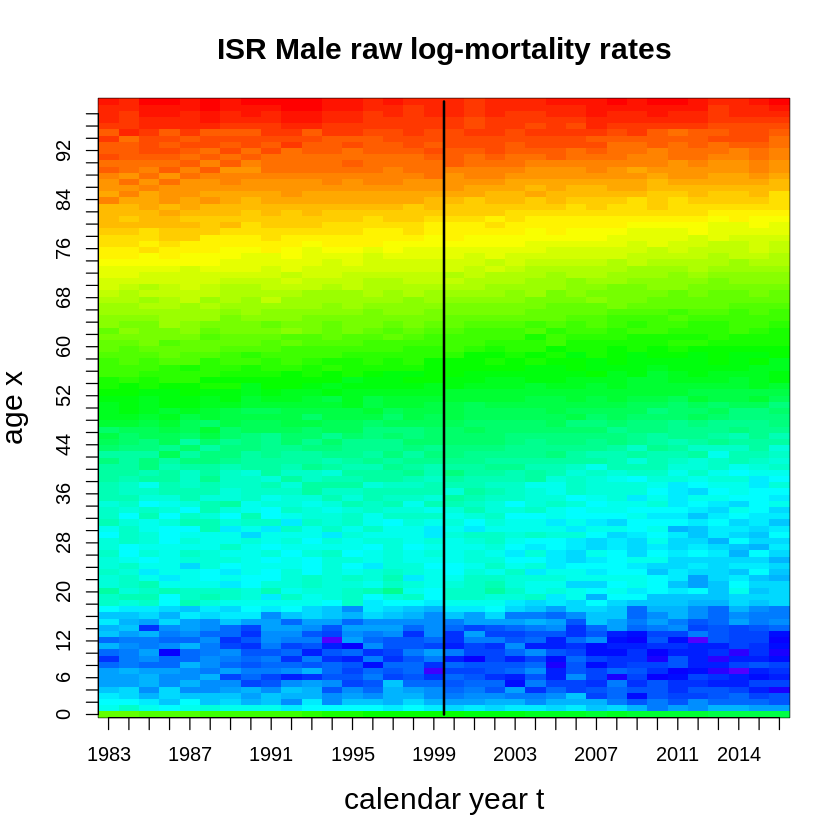

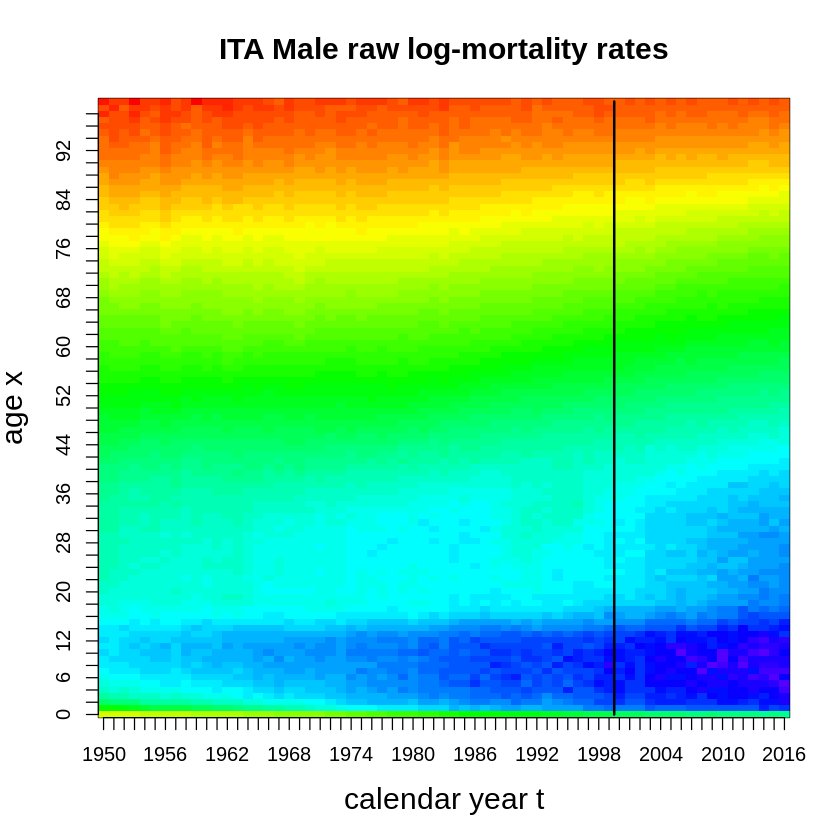

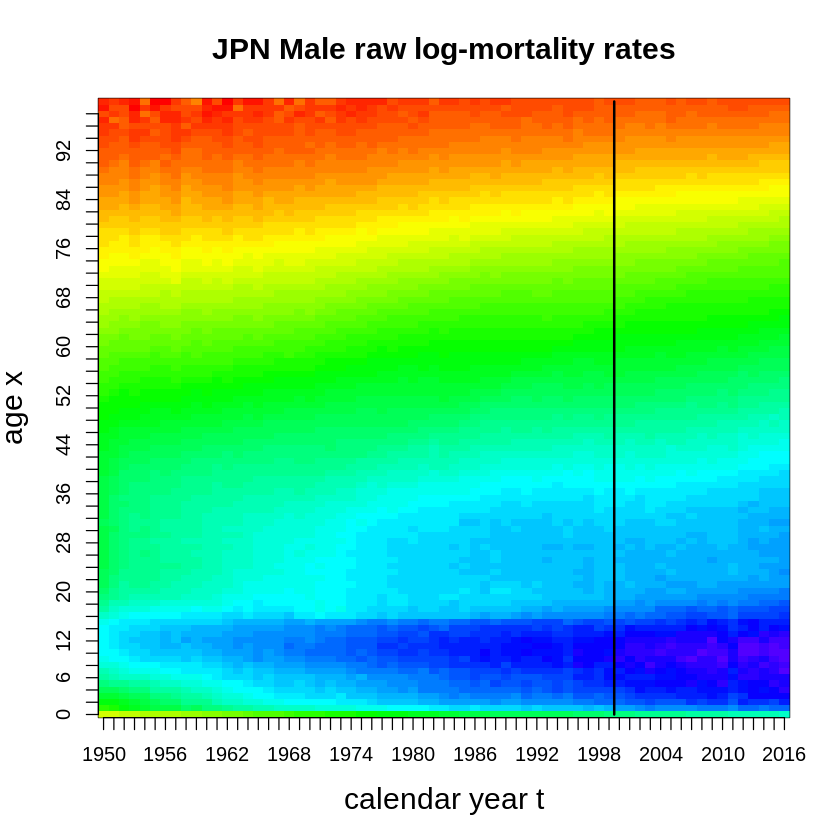

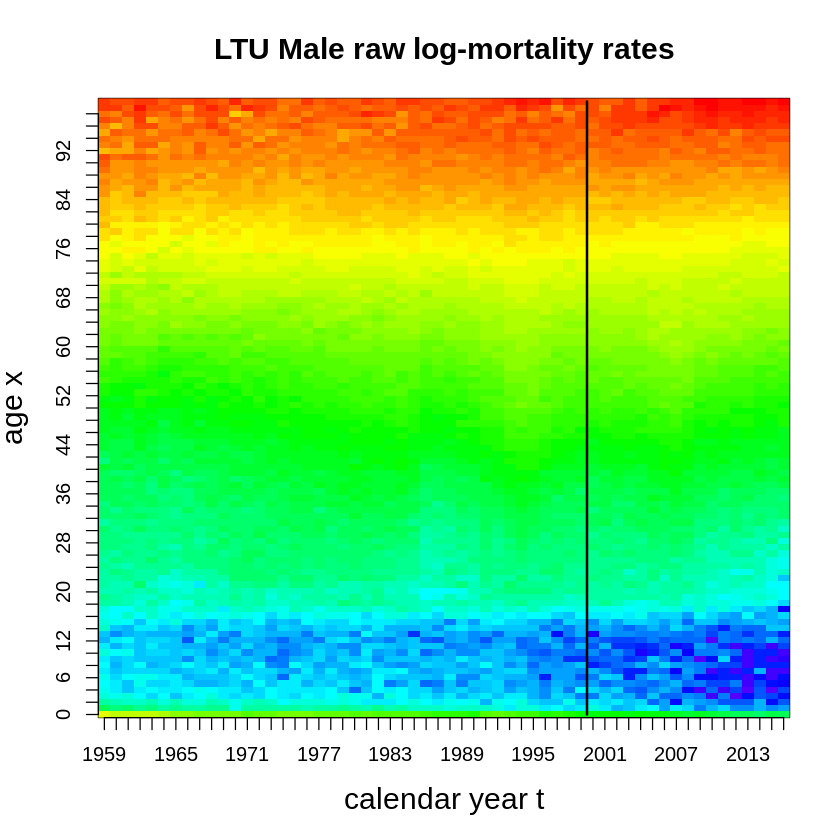

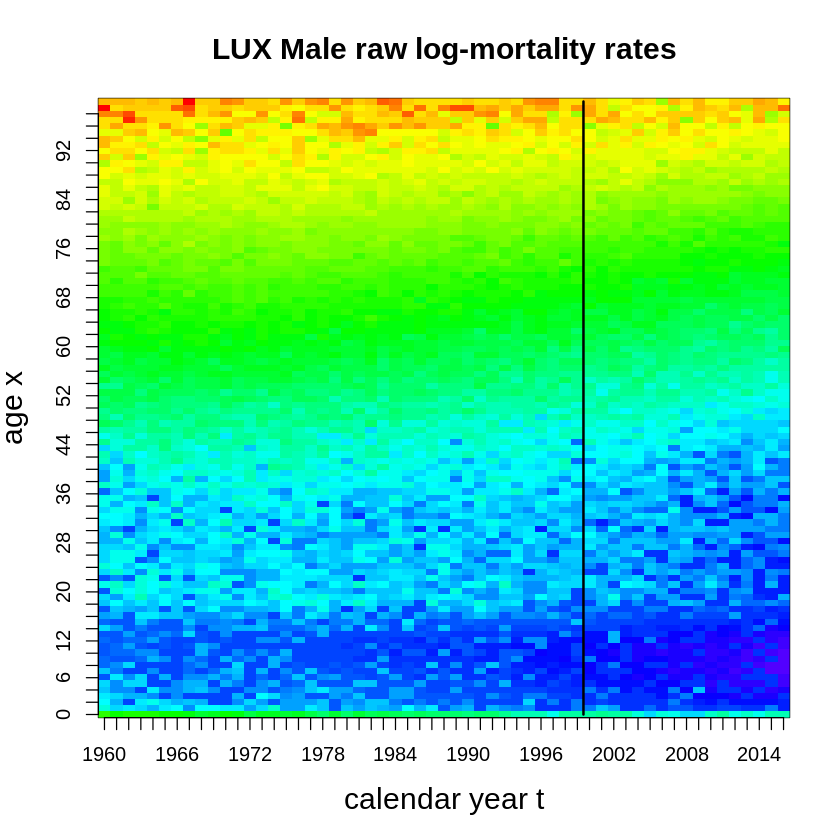

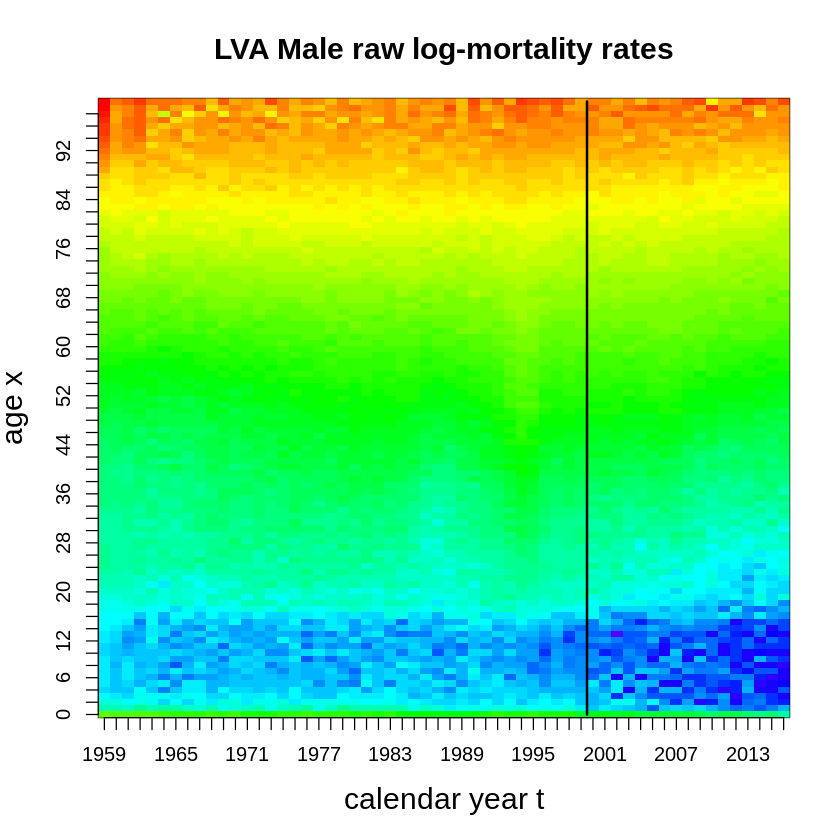

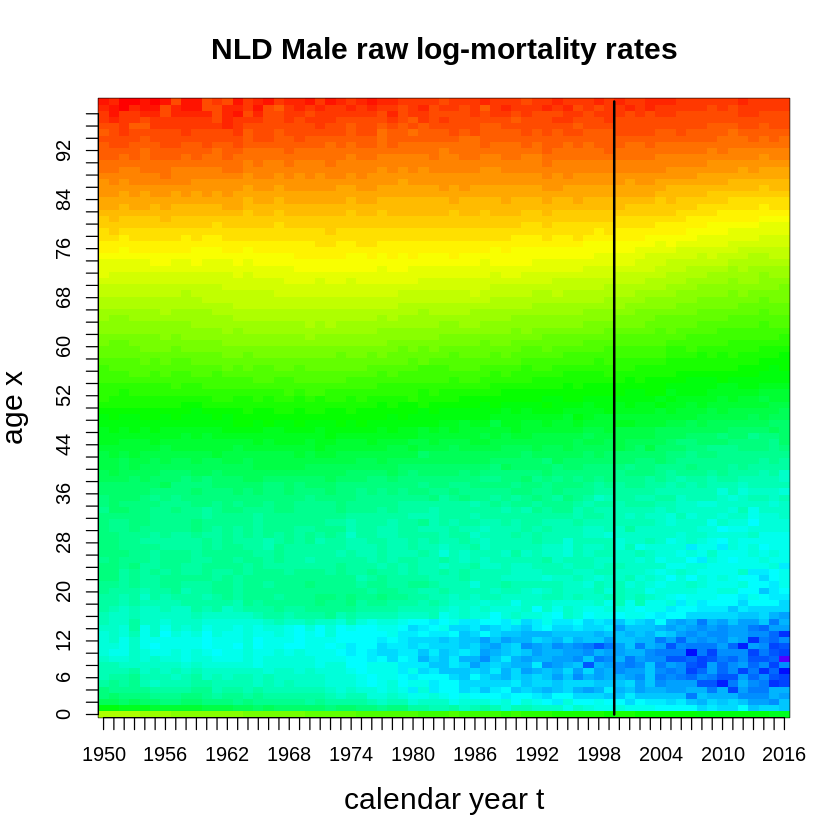

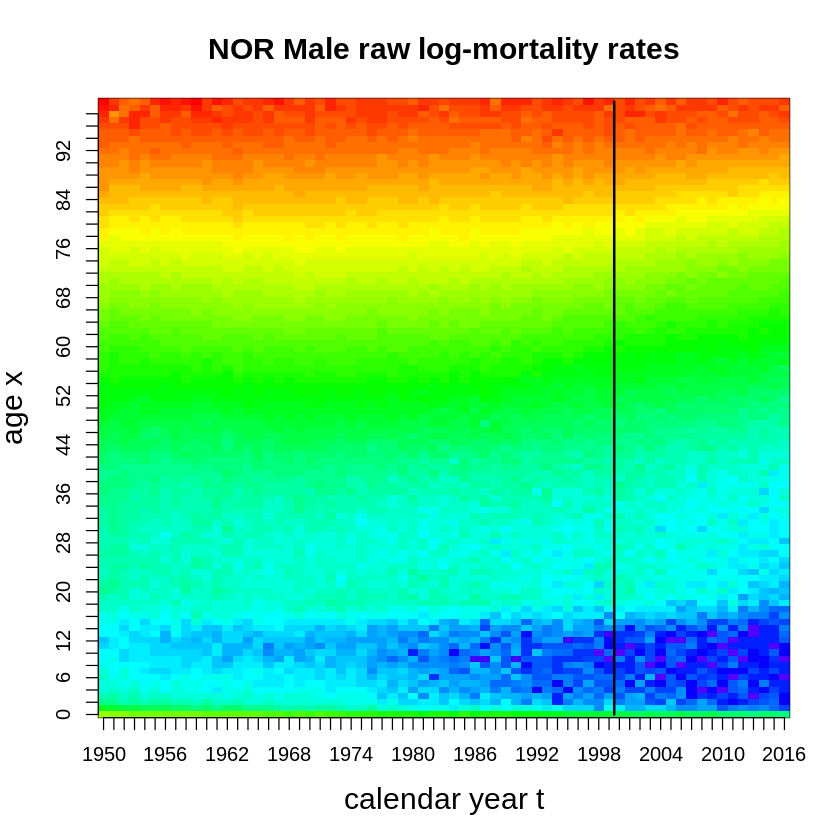

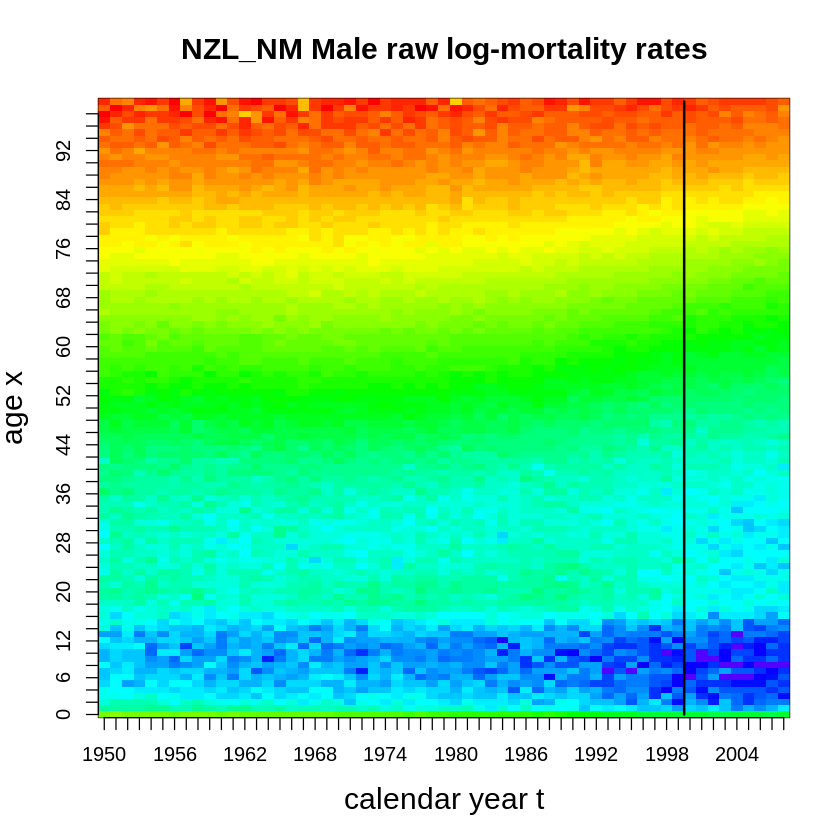

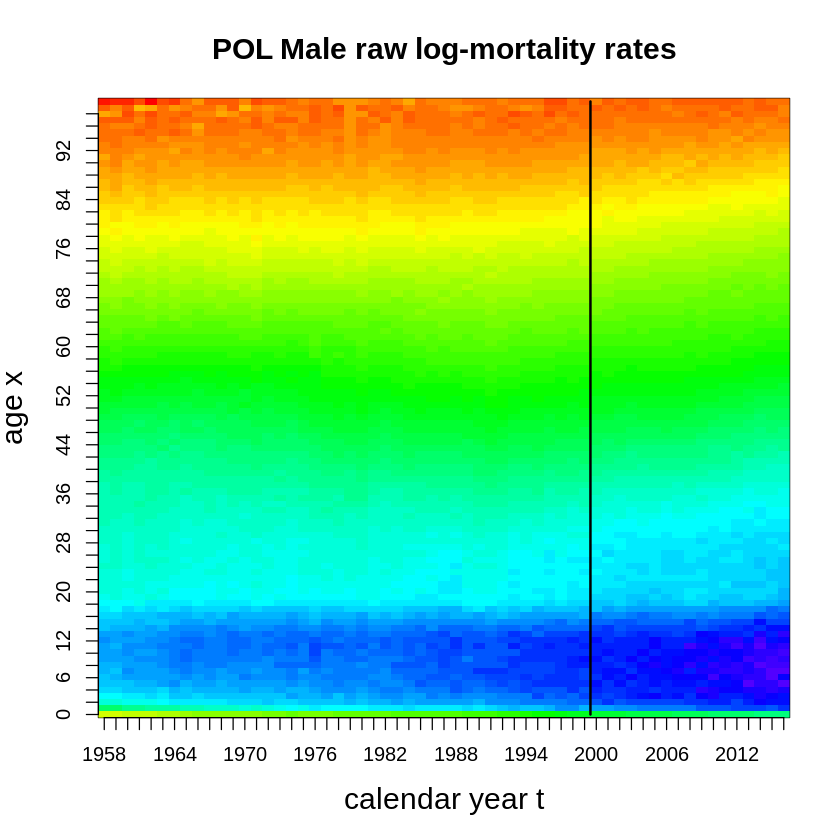

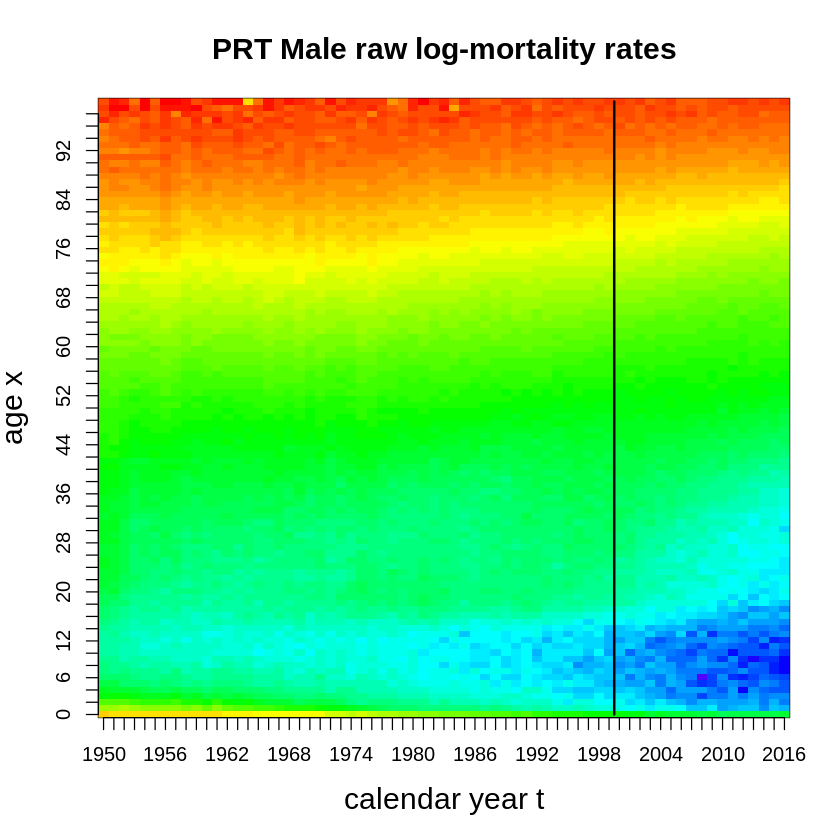

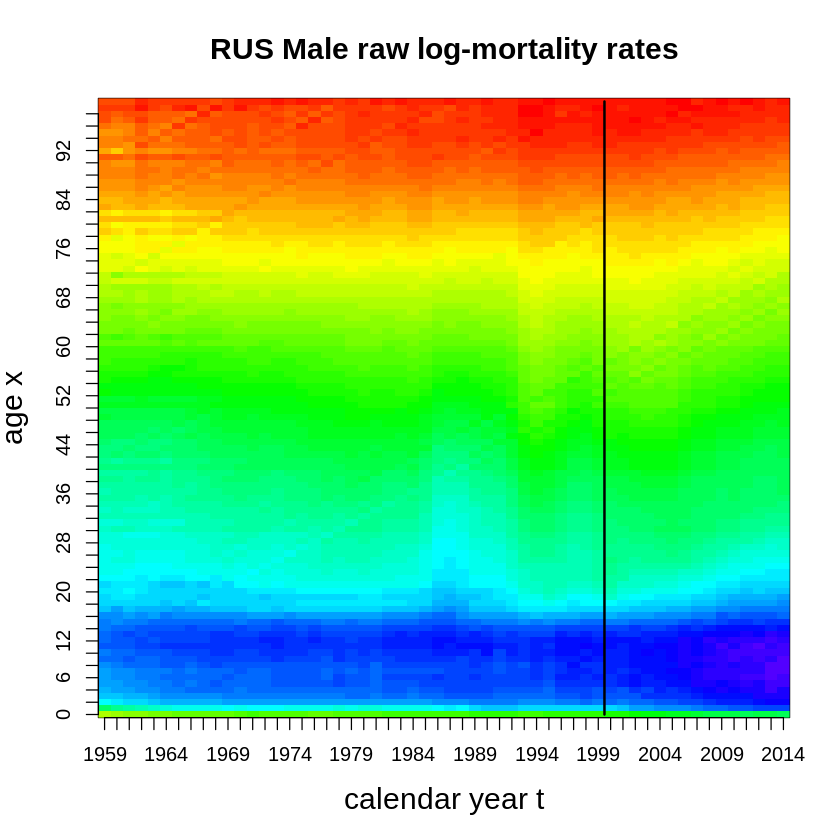

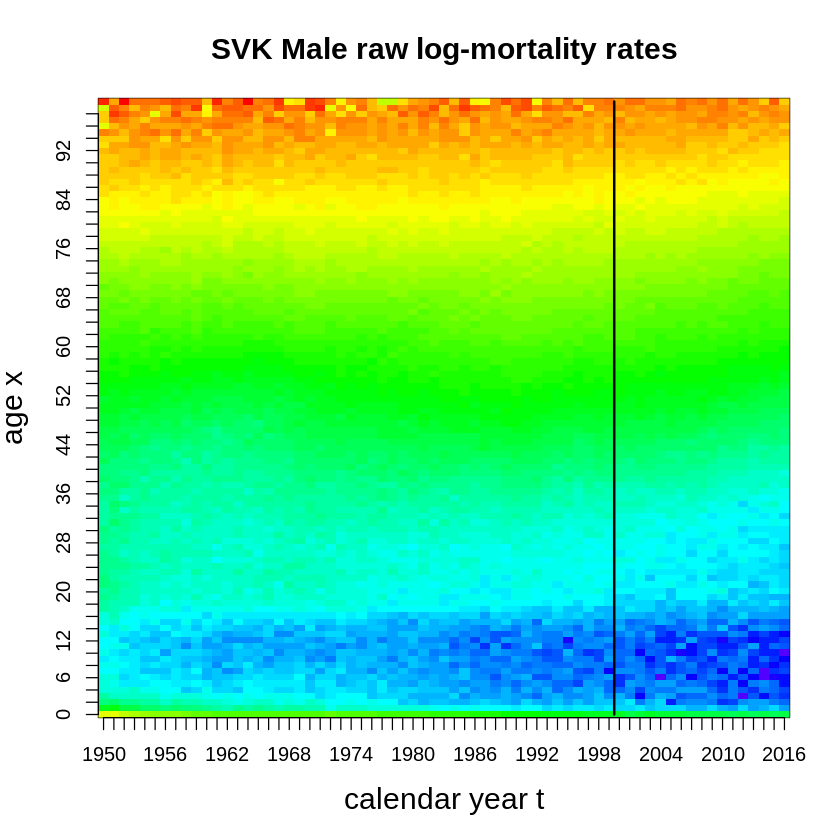

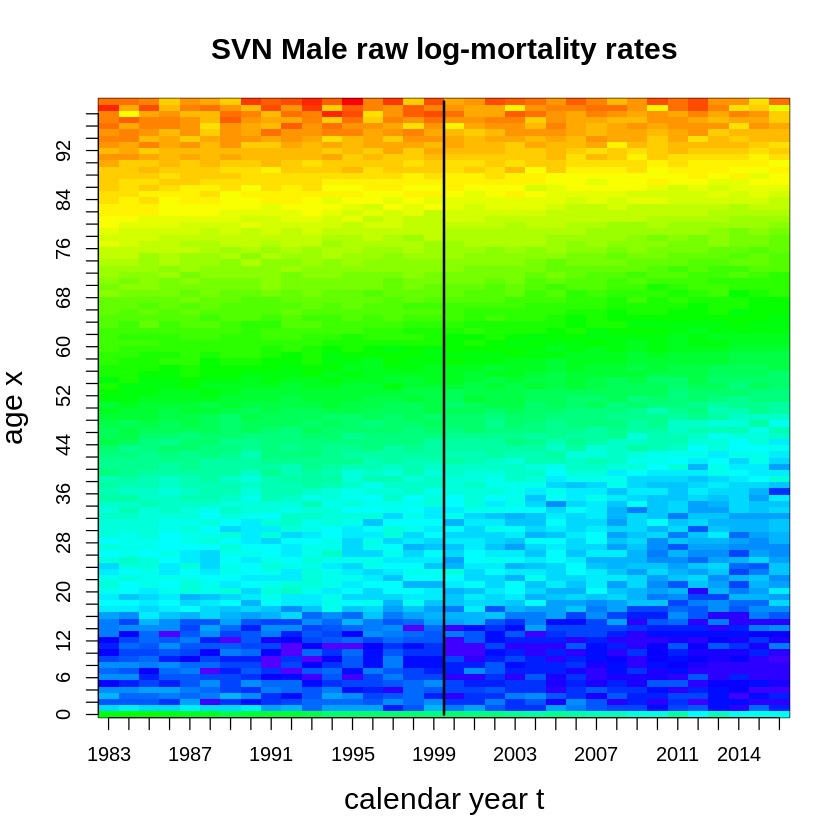

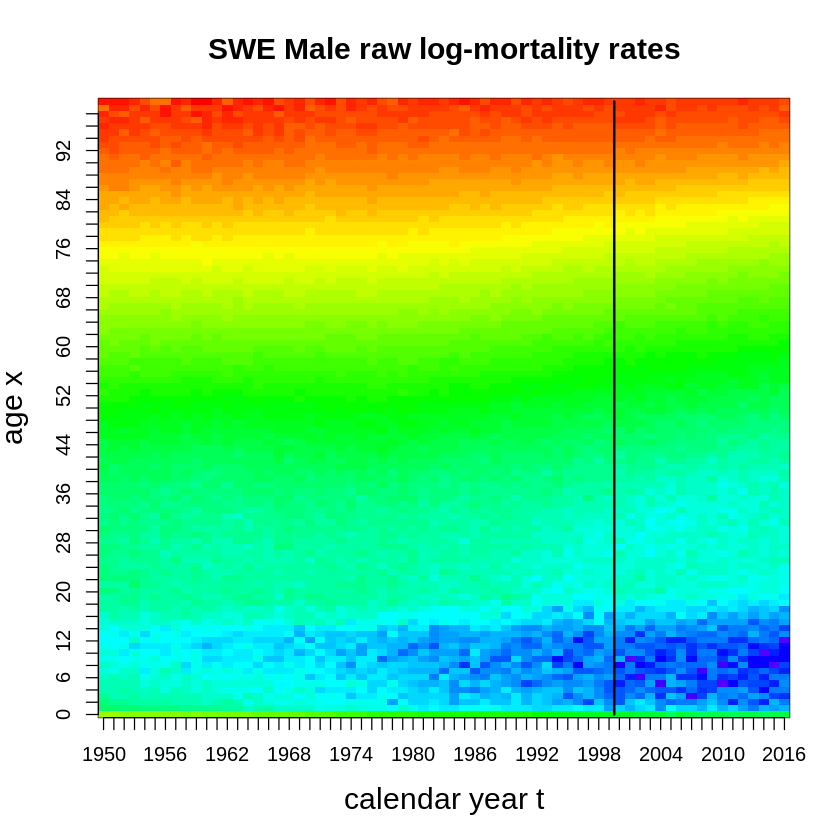

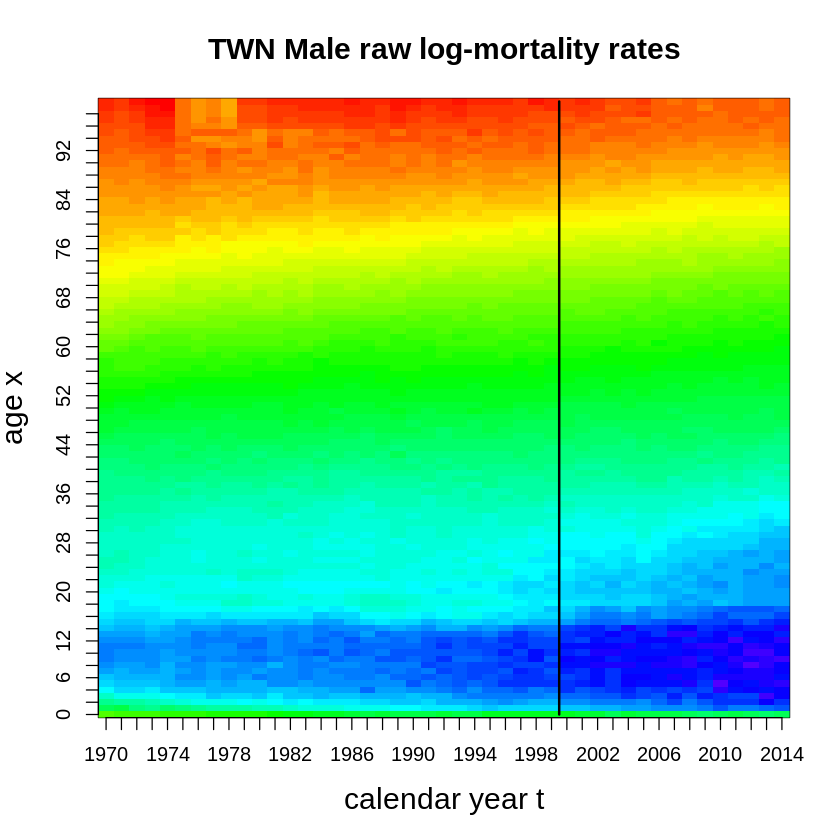

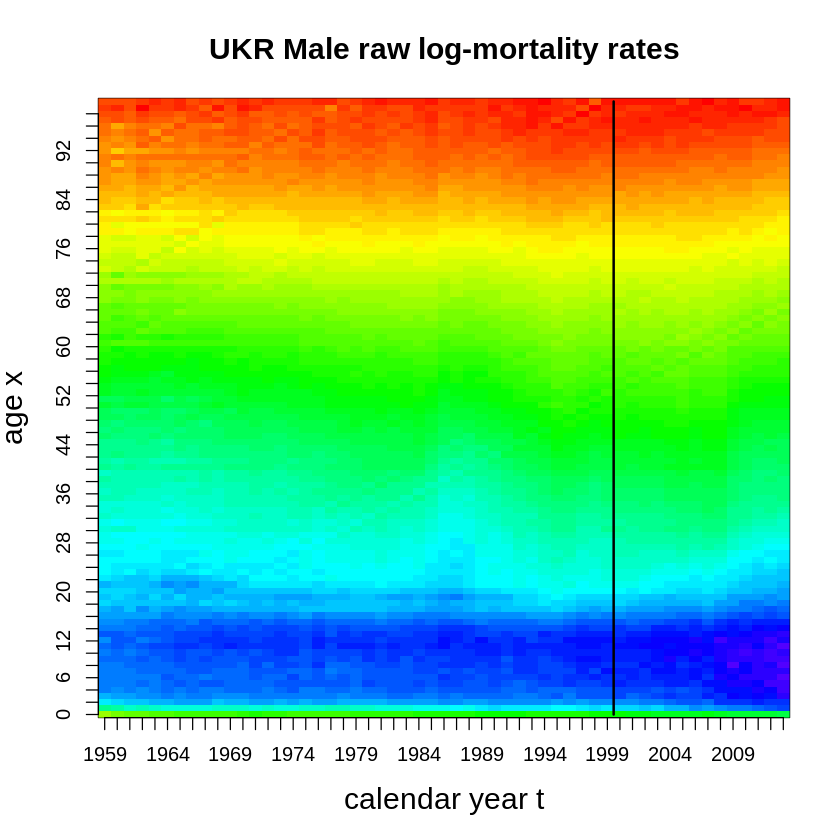

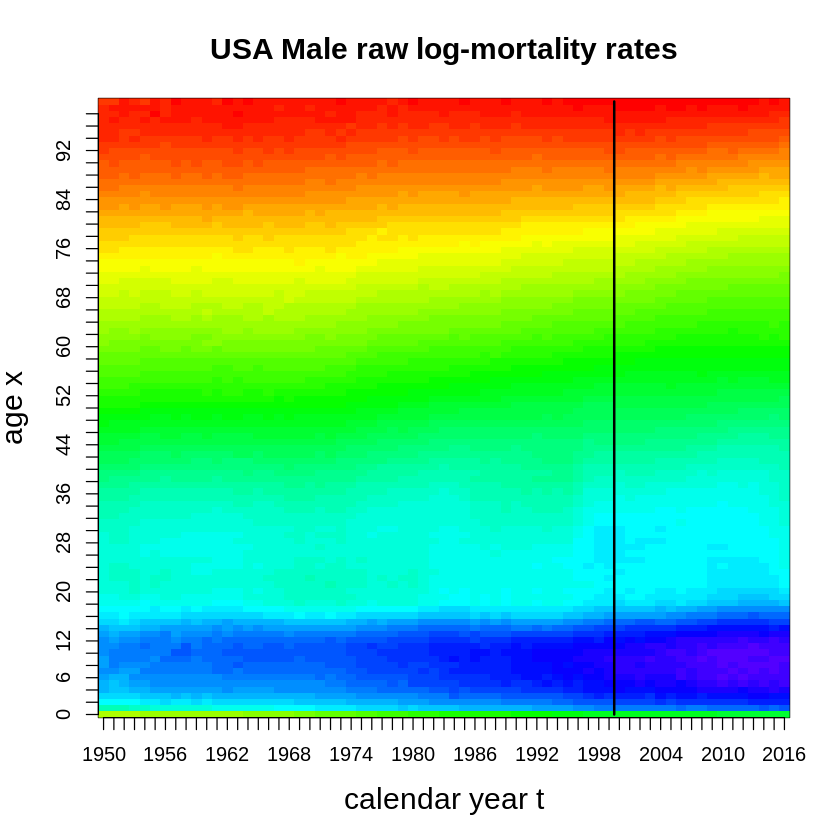

In [14]:
Genders <- tibble(Gender = c("Female","Male"))
Countries <- HMD_final %>% select(Country) %>% distinct()


for(g in unlist(Genders)){
  for(c in unlist(Countries)){
    tmp <- HMD_final %>% filter(Gender == g, Country == c) %>% select(Age,Year, logmx) %>%
      pivot_wider(names_from = Age, values_from = logmx)
    year_min <- tmp %>% select(Year) %>% min()
    year_max <- tmp %>% select(Year) %>% max()
    tmp <- tmp %>% select(-Year) %>% as.matrix()
    mortality_heatmap(tmp, c, g, year_min, year_max)    
  }
}

### Data scaling
MinMaxScaling on logmx on whole dataset

In [21]:
val.min <- HMD_final %>% summarize(min(logmx)) %>% unlist()
val.max <- HMD_final %>% summarize(max(logmx)) %>% unlist()
HMD_final <- HMD_final %>% mutate(val = (logmx - val.min)/(val.max-val.min))

### Setting up training set

creating the training set (all observation up to 1999) based on mx values only (with data.preprocessing.CNNs function) <br>
Each yt observation is equal to a whole mortality curve and xt was equal to ten previous mortality curves (matrix 10:100). <br>
It was done only when all ten previous curves where available for given country.


In [23]:
Genders <- c("Male","Female")
Countries <- HMD_final %>% select(Country) %>% distinct() %>% unlist()

VecGenders <- vector()
VecCountries <- vector()

ListData <- list()

obs <-0
for(c in 1:length(Countries)){
  for(g in 1:2){
    data <- data.preprocessing.CNNs(HMD_final,Genders[g],Countries[c],T0, ObsYear)
    n <- dim(data[[1]])[1]
    obs <- obs + n
    ListData[[(c-1)*2 + g]] <- data
    # VecGenders (with 0 or 1 for each observation)
    VecGenders<- c(VecGenders,rep(g-1,n))
    # VecCounties (with number from 0 to 37 corresponding to each country for each observation)
    VecCountries <- c(VecCountries,rep(c-1,n))
  }
}

Binding observations form different countries into one dataset <br>
Sorting data in time order <br>
transformation of xtrain from data.preprocessing.CNNs to list of previous xtrain, veccountries and vecgender


In [25]:
x.train <- array(NA, dim=c(obs, dim(ListData[[1]][[1]])[c(2,3)]))
y.train <- array(NA, dim=c(obs,1,dim(ListData[[1]][[2]])[2]))
obsYearVec <- vector()

counter = 0
for (i in 1:(g*c)){
  n <- dim(ListData[[i]][[1]])[1]
  obsYearVec <- c(obsYearVec,ListData[[i]][[3]] )
  for(j in 1:n){
    x.train[counter+j,,] <- ListData[[i]][[1]][j,,]
    y.train[counter+j,1,] <- ListData[[i]][[2]][j,]
  }
  counter <- counter + n
}

# sort to be in time order
OrderByYear <- order(obsYearVec)

x.train.sorted <- x.train[OrderByYear,,]
y.train.sorted <- y.train[OrderByYear,,]
dim(y.train.sorted) <- c(2662,1,100)
VecGenders.sorted <- VecGenders[OrderByYear]
VecCountries.sorted <- VecCountries[OrderByYear]

x.train <- list(x.train.sorted, VecCountries.sorted, VecGenders.sorted)
y.train <- y.train.sorted    


## Modelling
### Setting up model

In [51]:
if(model_type == "CNN"){
  model <- CNN(N, T0)
} else if(model_type == "LSTM"){
  model <- LSTM(N,T0)  
} else
{
  stop("Wrong arcitecture specified within model_type variable")
}
        
modelName = paste(model_type ,T0, sep ="_")
fileName <- paste(wd,"CallBack/best_model_", modelName, sep="")

[1] "/home/as/Pulpit/ADS/Analizy/Own/CNN LC/LC CNN/CallBack/best_model_LSTM_10"

[1] "/home/as/Pulpit/ADS/Analizy/Own/CNN LC/LC CNN/"

In [45]:
summary(model)

Model: "model_1"
________________________________________________________________________________
Layer (type)              Output Shape      Param #  Connected to               
rates (InputLayer)        [(None, 10, 100)] 0                                   
________________________________________________________________________________
lstm (LSTM)               (None, 128)       117248   rates[0][0]                
________________________________________________________________________________
Country (InputLayer)      [(None, 1)]       0                                   
________________________________________________________________________________
Gender (InputLayer)       [(None, 1)]       0                                   
________________________________________________________________________________
batch_normalization_1 (Ba (None, 128)       512      lstm[0][0]                 
________________________________________________________________________________
embedding_2

### Defining custom callback
Callback produce plot of loss and validation loss on specified interval as Jupyter Notebook does not allow for automatic plot from model fitting

In [28]:
TrainingPlotFactory <- R6Class("TrainingPlot",
  inherit = KerasCallback,
  
  public = list(
    
    i = NULL,
    x = NULL,
    losses = NULL,
    val_losses = NULL,
    logs = NULL,
    epoch = NULL,
    plot_interval = 10,
      
    on_train_begin = function(logs = list()){
        self$i = 0
        self$x = vector()
        self$losses = vector()
        self$val_losses = vector()
        self$logs = list()
    },
     
    on_epoch_end = function(epoch, logs = list()) {
        self$logs <- c(self$logs, logs)
        self$x <- c(self$x, self$i)
        self$losses <- c(self$losses, logs[['loss']])
        self$val_losses <- c(self$val_losses, logs[['val_loss']])
        self$i = self$i + 1
        
        # Basic line plot with points
        if(self$i %% self$plot_interval == 0){
            ymax = max(TrainingPlotCB$losses,TrainingPlotCB$val_losses)
            plot(1, type="n", xlab="", ylab="", xlim=c(0, epochs), ylim=c(0, ymax))
            lines(TrainingPlotCB$x, TrainingPlotCB$losses, type="l", col = "red")
            lines(TrainingPlotCB$x, TrainingPlotCB$val_losses, type = "l", col = "green")
            legend(0, ymax, legend=c("Losses", "Val losses"),
               col=c("red", "green"), lty=1:2, cex=0.8)
        }
    }
))

### Defining other callbacks

In [46]:
model_callback <- callback_model_checkpoint(fileName, monitor = "val_loss", verbose = 1,  save_best_only = TRUE, save_weights_only = TRUE)

lr_callback <- callback_reduce_lr_on_plateau(factor=.90, patience = 
                                              50, verbose=1, cooldown = 5, min_lr = 0.00005)

if(plotEpochs){
    TrainingPlotCB <- TrainingPlotFactory$new()
    TrainingPlotCB$plot_interval <- plot_interval
    CBs <- list(model_callback, lr_callback,TrainingPlotCB)
} else {
    CBs <- list(model_callback, lr_callback)
}

### Model fitting
With gradient decent (ADAM optimizer)

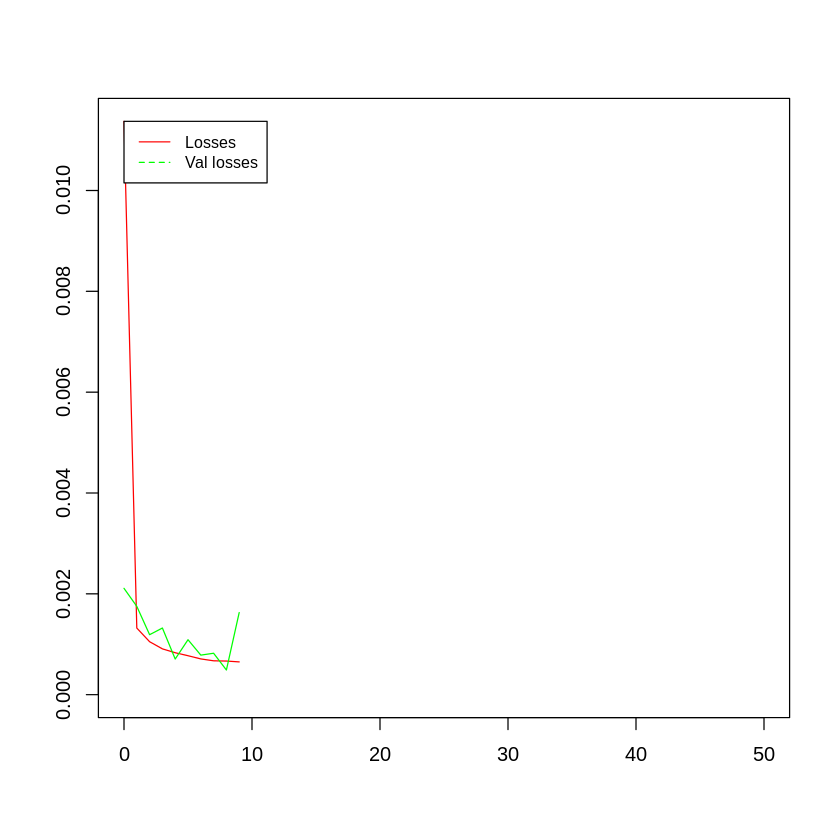

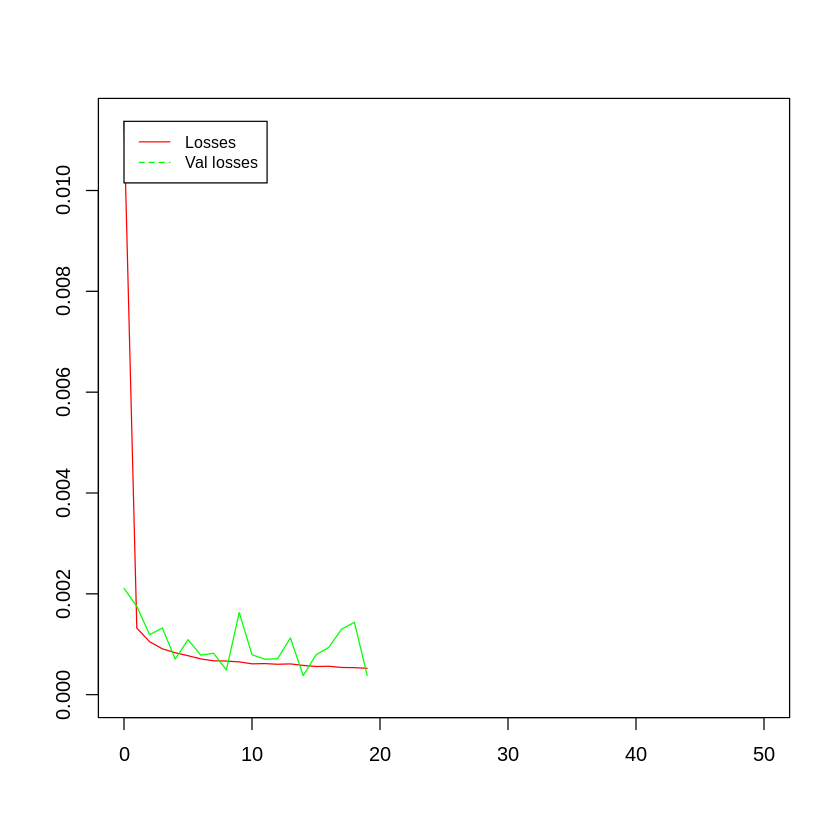

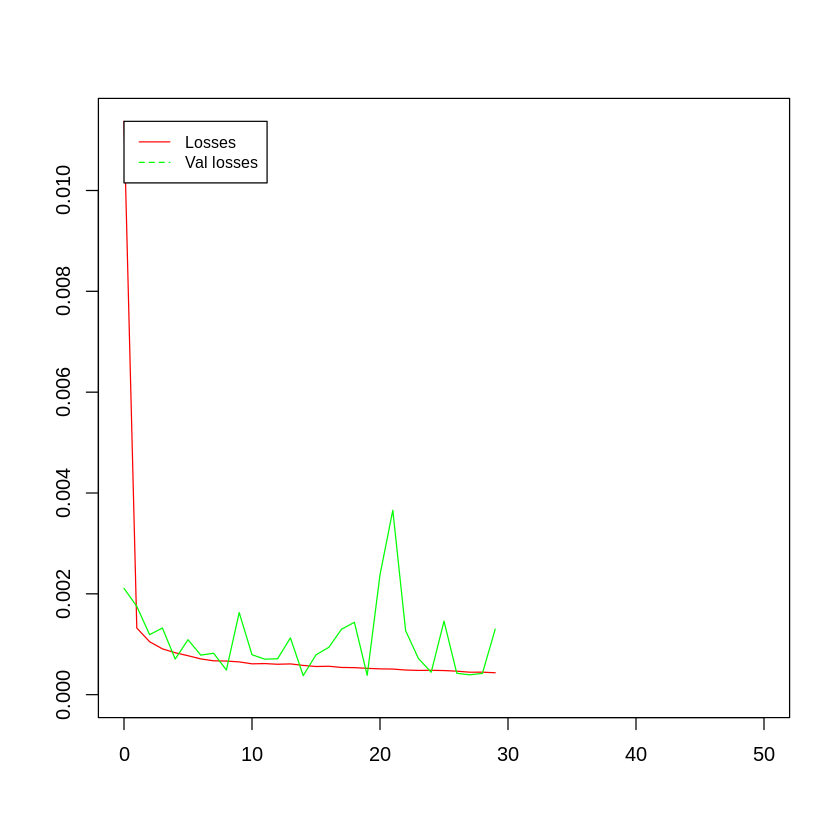

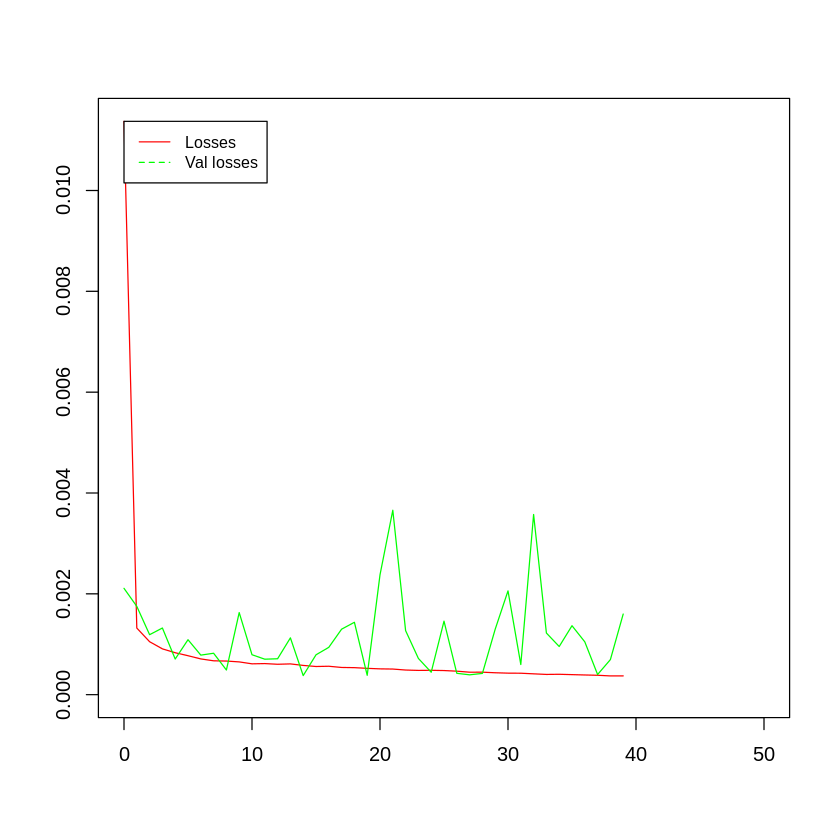

   user  system elapsed 
500.066  22.102 249.528 

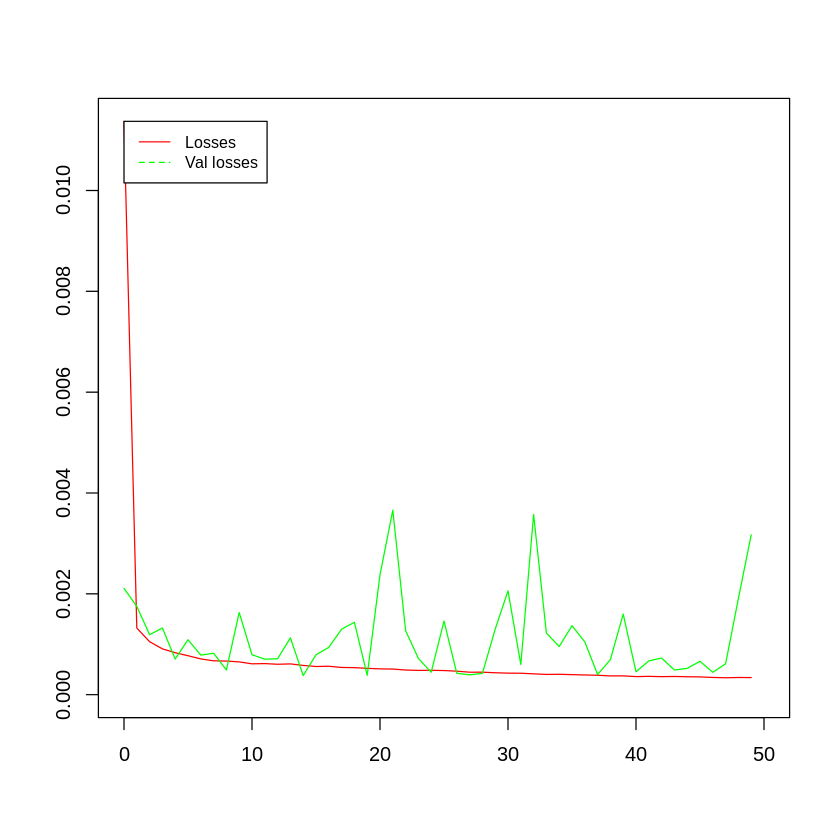

In [47]:
t1 <- proc.time()
    fit <- model %>% fit(x=x.train, y=y.train, epochs = epochs, 
                         batch_size =16, 
            verbose = 2, validation_split = 0.05, shuffle = T,callbacks=CBs)                             
proc.time()-t1

### in-sample error (validation)

`geom_smooth()` using formula 'y ~ x'



[1] 0.0007876559

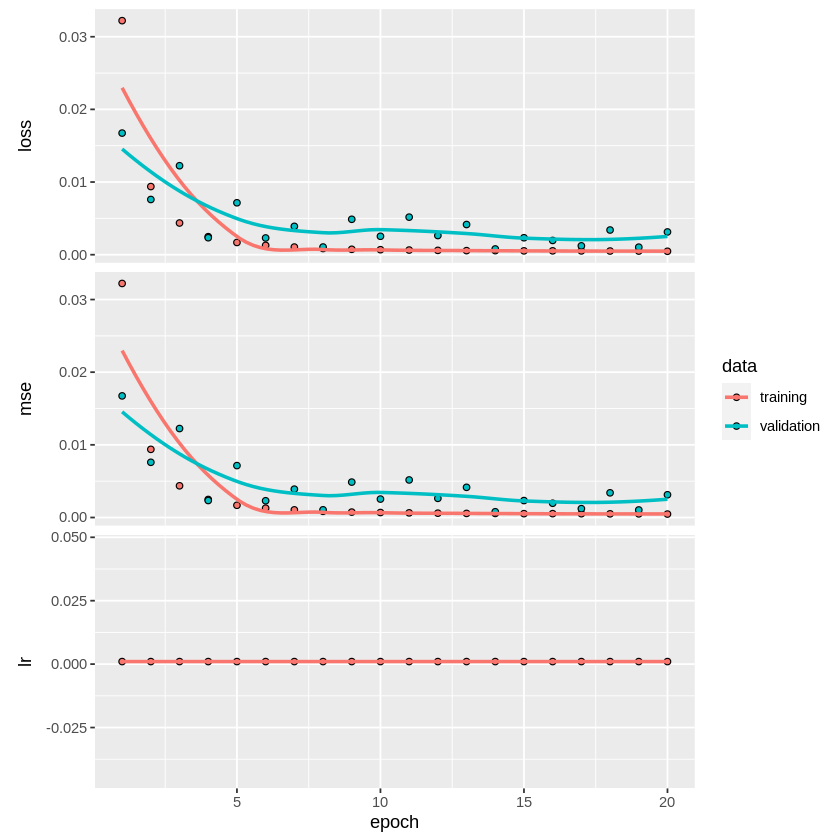

In [33]:
   
plot(fit)

fit$metrics$val_loss%>%min()



## Prediction
### Loading best model

In [37]:
load_model_weights_hdf5(model, fileName)    

### Setting up test data

In [39]:
testData <- HMD_final %>% filter(Year > (ObsYear - 10))

### Example prediction

In [ ]:
pred.CHE.F <- recursive.prediction(1999, testData, "Female", "CHE",(match("CHE", Countries)-1),T0, val.min, val.max, model)
pred.POL.M <- recursive.prediction(1999, testData, "Male", "POL",(match("POL", Countries)-1),T0, val.min, val.max, model)

Errors from example prediction

In [ ]:
pred.CHE.F[[2]]
pred.POL.M[[2]]